In [1]:
import numpy as np
import scipy.stats as spst

import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as spsp

import json
import re
from pandas.io.json import json_normalize

import scipy.optimize as spopt

### The data in this .history file although have registered a startScraperDelay = 54000 they have been carried out at 29000 (end of 3.547GeV/c) there was an issue with Bryno application that has then been solved

In [2]:
#Import file with data scraper from AD
jsonFile = 'DataMD26July2023.history'
# convert json file to pandas
# read scraper data from JSON
scraperData = []
with open(jsonFile) as infile:
    lines = infile.readlines()
    for i, line in enumerate(lines):
        try:
            scraperData.append(json.loads(line))
        except:
            print('something wrong with line {}'.format(i))

scraperDataPD26july2023 = json_normalize(scraperData, max_level=2)

/tmp/ipykernel_803/661173479.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  scraperDataPD26july2023 = json_normalize(scraperData, max_level=2)


In [3]:
#Import file with data scraper from AD
jsonFile = 'Data27July2023OrbitCorrectionVTuneChanged.history'
# convert json file to pandas
# read scraper data from JSON
scraperData = []
with open(jsonFile) as infile:
    lines = infile.readlines()
    for i, line in enumerate(lines):
        try:
            scraperData.append(json.loads(line))
        except:
            print('something wrong with line {}'.format(i))

scraperDataPD27july2023 = json_normalize(scraperData, max_level=2)

/tmp/ipykernel_803/1271713215.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  scraperDataPD27july2023 = json_normalize(scraperData, max_level=2)


In [4]:
#Import file with data scraper from AD
jsonFile = 'Acceptance100MeV_30August2023.history'
# convert json file to pandas
# read scraper data from JSON
scraperData = []
with open(jsonFile) as infile:
    lines = infile.readlines()
    for i, line in enumerate(lines):
        try:
            scraperData.append(json.loads(line))
        except:
            print('something wrong with line {}'.format(i))

scraperDataPD30August2023 = json_normalize(scraperData, max_level=2)

/tmp/ipykernel_803/1587266494.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  scraperDataPD30August2023 = json_normalize(scraperData, max_level=2)


In [5]:
df = pd.concat([scraperDataPD26july2023[scraperDataPD26july2023["dataScraperOriginTime"].str.contains("2023/07/26")].iloc[17:], 
                scraperDataPD27july2023, scraperDataPD30August2023.iloc[-11:]])

# Plot non-normalised losses and scraper velocity

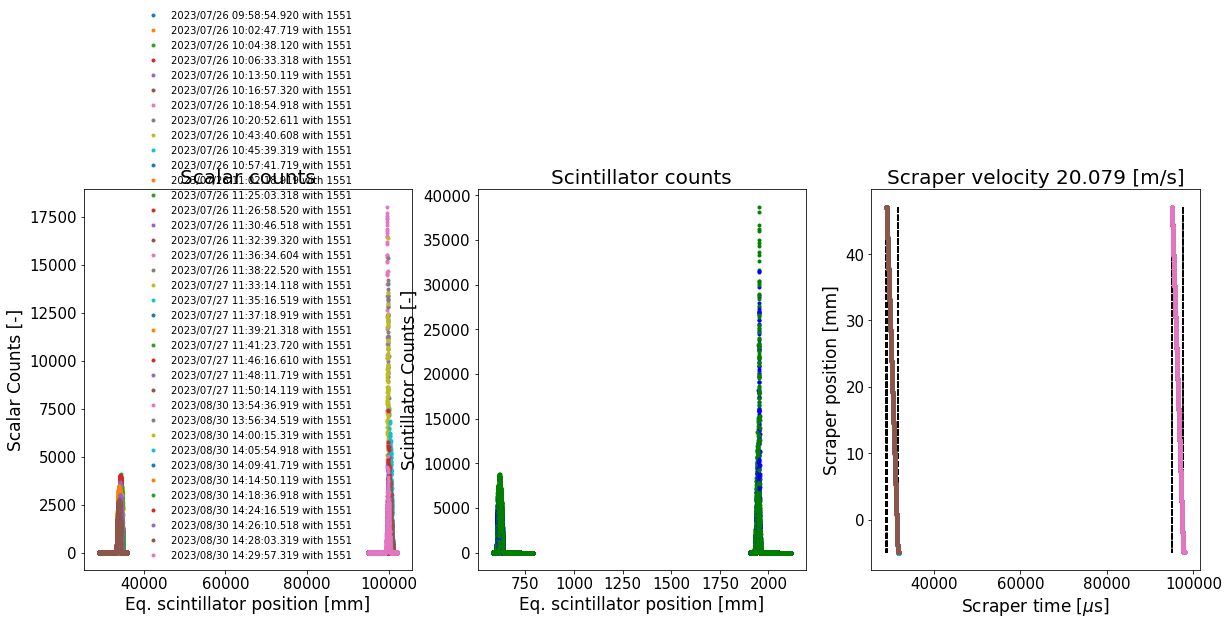

In [6]:
f, ax = plt.subplots(1, 3, figsize = (20, 7), sharex = False, sharey = False)
for h in range(len(df.originUtcTime.values)):

    ScraperStart = np.where(np.diff(np.array(df.scraperY.iloc[h]))<-0.03)[0][0]
    ScraperEnd = np.where(np.diff(np.array(df.scraperY.iloc[h]))<-0.03)[0][-1]

    delta_time_scraper = np.abs(df.scraperXms.iloc[h][ScraperStart] - df.scraperXms.iloc[h][ScraperEnd] )

    VelocityScraper = (max(df.scraperY.iloc[h]) - min(df.scraperY.iloc[h])) / delta_time_scraper

    # scalar plot
    ax[0].set_title("Scalar counts", size = 20)
    
    limit = 0.01
    ydata_scalar = df["det3.yval"].iloc[h][0][::-1]
    xdata_scalar = np.array(df["det3.xms"].iloc[h])# * VelocityScraper
#     print(max(xdata_scalar)- min(xdata_scalar))
    
    ax[0].plot( xdata_scalar, ydata_scalar, ".", label = "%s with %1.0f"%(df["dataScraperOriginTime"].iloc[h], len(xdata_scalar)) )
    
    ax[0].set_xlabel("Eq. scintillator position [mm]", size = 17)
    ax[0].set_ylabel("Scalar Counts [-]", size = 17)
    ax[0].tick_params(axis = "both", which = "major", labelsize = 15)
    
    # scintillator plot
    ax[1].set_title("Scintillator counts", size = 20)
    xdata_scint = np.array(df["det1.xms"].iloc[h])*VelocityScraper
    ydata_scint1 = np.array(df["det1.yval"].iloc[h][1])
    ydata_scint2 = np.array(df["det1.yval"].iloc[h][0])
    ax[1].plot( xdata_scint, ydata_scint1, ".b" )
    ax[1].plot( xdata_scint, ydata_scint2, ".g" )
    
    ax[1].set_xlabel("Eq. scintillator position [mm]", size = 17)
    ax[1].set_ylabel("Scintillator Counts [-]", size = 17)
    ax[1].tick_params(axis = "both", which = "major", labelsize = 15)
    
    # scraper plot
    ax[2].set_title("Scraper velocity %1.3f [m/s]"%(VelocityScraper*1e3), size = 20)
    ax[2].plot(df["scraperXms"].iloc[h], df["scraperY"].iloc[h], ".", label = "%s"%df["dataScraperOriginTime"].iloc[h] )
    
    ax[2].vlines(x = df["scraperXms"].iloc[h][ScraperStart],ymin = max(df["scraperY"].iloc[h]), ymax = min(df["scraperY"].iloc[0]), 
                 color = "k", ls = "--")
    ax[2].vlines(x = df["scraperXms"].iloc[h][ScraperEnd],ymin = max(df["scraperY"].iloc[h]), ymax = min(df["scraperY"].iloc[0]), 
                 color = "k", ls = "--")
    
    ax[2].set_xlabel(r"Scraper time [$\mu$s]", size = 17)
    ax[2].set_ylabel("Scraper position [mm]", size = 17)
    ax[2].tick_params(axis = "both", which = "major", labelsize = 15)
ax[0].legend(frameon = False)

# Reconstruction beam profile with the ABEL transform and fit - COMPARISON

In [7]:
def ScraperLosses_V (x_scraper, RMS_emittance, x0):
    beta_scraper = 4.288 #m
    y = (x_scraper-x0)/beta_scraper/RMS_emittance * np.exp(- 0.5 * (x_scraper-x0)**2/beta_scraper/RMS_emittance )
    return y

def ScraperLosses_H (x_scraper, RMS_emittance, x0):
    beta_scraper = 4.975 #m
    y = (x_scraper-x0)/beta_scraper/RMS_emittance * np.exp(- 0.5 * (x_scraper-x0)**2/beta_scraper/RMS_emittance )
    return y

In [8]:
def Gauss_Fit_V (x, ampl, RMS_emittance):
    beta_scraper = 4.288
    y = ampl * 1/np.sqrt(2.*np.pi*beta_scraper*RMS_emittance) * np.exp( -0.5 * (x)**2 / (beta_scraper*RMS_emittance))
#     print("V***", np.sqrt(beta_scraper*RMS_emittance)*1e3, "***")
    return y

def Gauss_Fit_H (x, ampl, RMS_emittance):
    beta_scraper = 4.975
    y = ampl * 1/np.sqrt(2.*np.pi*beta_scraper*RMS_emittance) * np.exp( -0.5 * (x)**2 / (beta_scraper*RMS_emittance))
#     print("H***", np.sqrt(beta_scraper*RMS_emittance)*1e3, "***")
    return y

In [9]:
def ForwardAbelTransform (*InputVariables, MinValueLosses, MinPointsInRisingEdge, MaximumOffset):
    if len(InputVariables) == 0:
        print("Error, you didn't put any input variable, please enter variables: scraper position and scintillator losses")
    elif len(InputVariables) == 1:
        print("Error, you didn't put all the needed variable, please enter variables BOTH: scraper position and scintillator losses")
    elif len(InputVariables) > 2:
        print("Error, too many input variables, please check input variables")
    elif len(InputVariables) == 2:
        print("Valid, all the needed variables have been inserted")
        
        
        ScraperPos = InputVariables[0]
        Losses = InputVariables [1] / max(InputVariables [1] )
        ##UPGRADE: find the first non-zero point
        Ind_LargerZero = np.where(Losses>MinValueLosses)[0][0]
        print("First non-zero point in losses", Ind_LargerZero)  
        if Ind_LargerZero == 0:
            CumulativeFunction = [] # Function where I collect the value of the integrals
        else:
            CumulativeFunction = np.ones(Ind_LargerZero) * np.nan
        ##UPGRADE: try to add oversampling if not enough points on the rising edge of the losses
        # In this configuration we are in the linear regime --> linear interpolation
        Ind_maxLosses = np.argmax(Losses) + MaximumOffset
        
        df = pd.DataFrame()
        df["x"] = ScraperPos
        df["y"] = Losses
        # start of oversampling
#         plt.figure()
#         plt.plot(ScraperPos, Losses, ".b")
        while(len(Losses[Ind_LargerZero:Ind_maxLosses+1])<MinPointsInRisingEdge):
            df_OverSampling = pd.DataFrame()
            AdditionalPoint_x, AdditionalPoint_y = np.array([]), np.array([])

            if len(Losses[Ind_LargerZero:Ind_maxLosses+1])<MinPointsInRisingEdge:
                #print("On the rising edge of the losses there are less than %i points, oversampling is performed"%MinPointsInRisingEdge)
                #AdditionalPoint_x, AdditionalPoint_y = np.zeros(Ind_maxLosses+1-Ind_LargerZero), np.zeros(Ind_maxLosses+1-Ind_LargerZero)
                for k, point in enumerate(Losses[Ind_LargerZero:Ind_maxLosses+1]):
                    AdditionalPoint_x = np.append(AdditionalPoint_x, ScraperPos[k+Ind_LargerZero] + (ScraperPos[(k+1)+Ind_LargerZero] - ScraperPos[k+Ind_LargerZero])/2)
                    AdditionalPoint_y = np.append(AdditionalPoint_y, Losses[k+Ind_LargerZero] + (Losses[(k+1)+Ind_LargerZero] - Losses[k+Ind_LargerZero])/2)
        
            df_OverSampling["x"] = AdditionalPoint_x
            df_OverSampling["y"] = AdditionalPoint_y
            df = pd.concat([df, df_OverSampling], ignore_index = True)
            df = df.sort_values(by=['x'])
            
            Ind_LargerZero = np.where(Losses>MinValueLosses)[0][0]
            Ind_maxLosses = np.argmax(Losses) + MaximumOffset
                        
            ScraperPos = df.x.values
            Losses = df.y.values
            
#             plt.plot(AdditionalPoint_x, AdditionalPoint_y, "xr")
            #plt.xlim([-1, 20])
        
        # Compute dx for the Abel Transform, dx is centred w.r.t. the numerical/experimental point --> rectangular integral
        dx = np.zeros(len(ScraperPos))
        for i in range(len(ScraperPos)):
            if i == 0 or i == len(ScraperPos)-1:
                dx[0] = (ScraperPos[1]-ScraperPos[0])*0.5
                dx[-1] = (ScraperPos[-1]-ScraperPos[-2])*0.5
            else:
                dx[i] = ((ScraperPos[i+1] - ScraperPos[i])*0.5 + ScraperPos[i]) - ((ScraperPos[i] - ScraperPos[i-1])*0.5 + ScraperPos[i-1])
        # Rectangular integral definition
        for h, y in enumerate(ScraperPos[Ind_LargerZero:], start = Ind_LargerZero):
            Numerator = Losses[h+1:] * dx[h+1:]
            x = ScraperPos[h+1:]
            # Denominator = np.append(1, np.sqrt(x[1:]**2 - y**2))
            Denominator = np.sqrt((x-ScraperPos[Ind_LargerZero])**2 - (y-ScraperPos[Ind_LargerZero])**2)

            temp = Numerator/Denominator

            CumulativeFunction = np.append(CumulativeFunction, sum(temp)/np.pi)
#         print(Ind_maxLosses)
        # calculation of the HWHM
        #plt.figure()
        #print("HFWM", ScraperPos[np.where(max(CumulativeFunction[Ind_LargerZero+1:])/2>CumulativeFunction[Ind_LargerZero+1:])[0][0]+Ind_LargerZero+1]*np.sqrt(2.*np.log(2))*1e-3)
        #plt.plot(ScraperPos[np.where(max(CumulativeFunction[Ind_LargerZero+1:])/2>CumulativeFunction[Ind_LargerZero+1:])[0][0]+Ind_LargerZero+1], CumulativeFunction[np.where(max(CumulativeFunction[Ind_LargerZero+1:])/2>CumulativeFunction[Ind_LargerZero+1:])[0][0]+Ind_LargerZero+1], "sg")
        #plt.plot(ScraperPos, CumulativeFunction, ".m")
        #plt.plot([0, 10], [max(CumulativeFunction[Ind_LargerZero+1:])/2, max(CumulativeFunction[Ind_LargerZero+1:])/2], "-r")
    return CumulativeFunction[~np.isnan(CumulativeFunction)], Ind_LargerZero, ScraperPos[~np.isnan(CumulativeFunction)]

# compute acceptance by measuring the 0-to-0 size of the beam between losses

/tmp/ipykernel_803/724601313.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, 2, figsize = (14, 7), sharex = False, sharey = False)


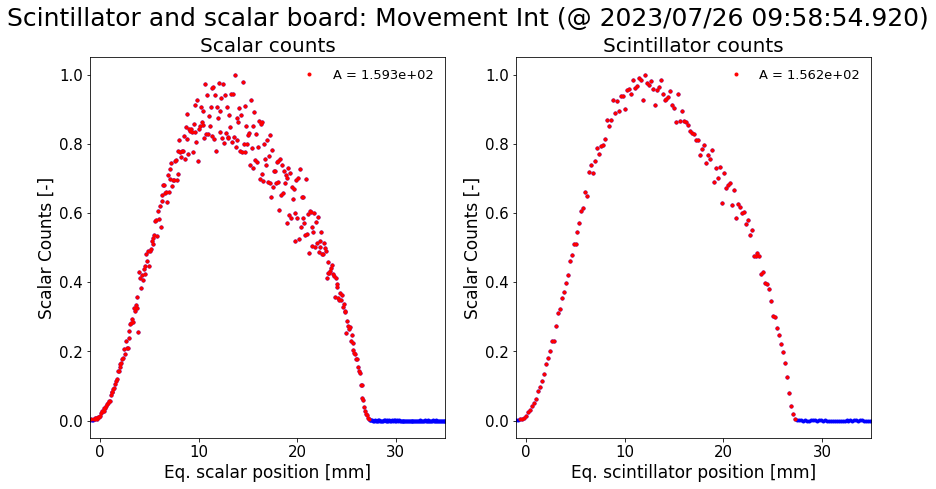

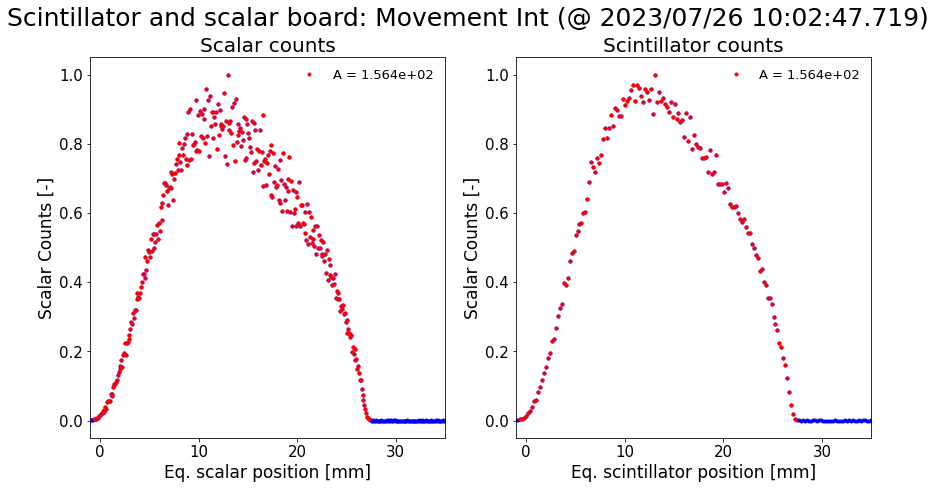

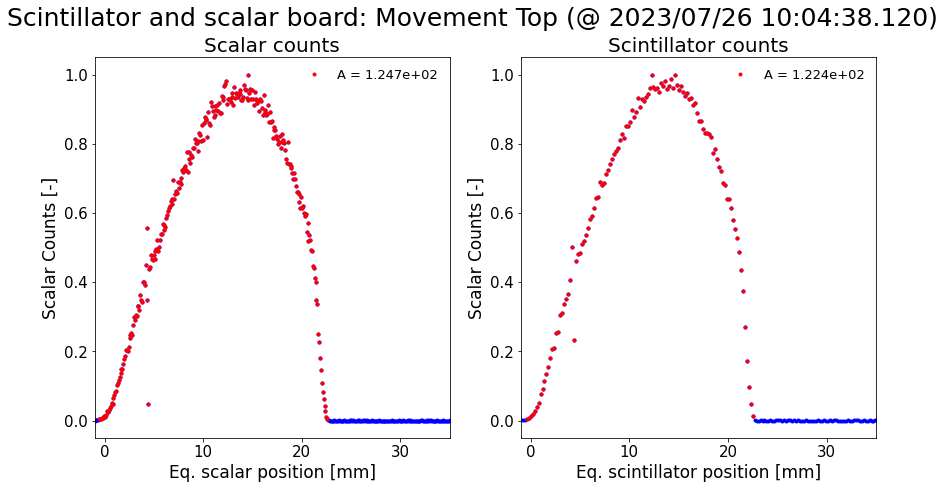

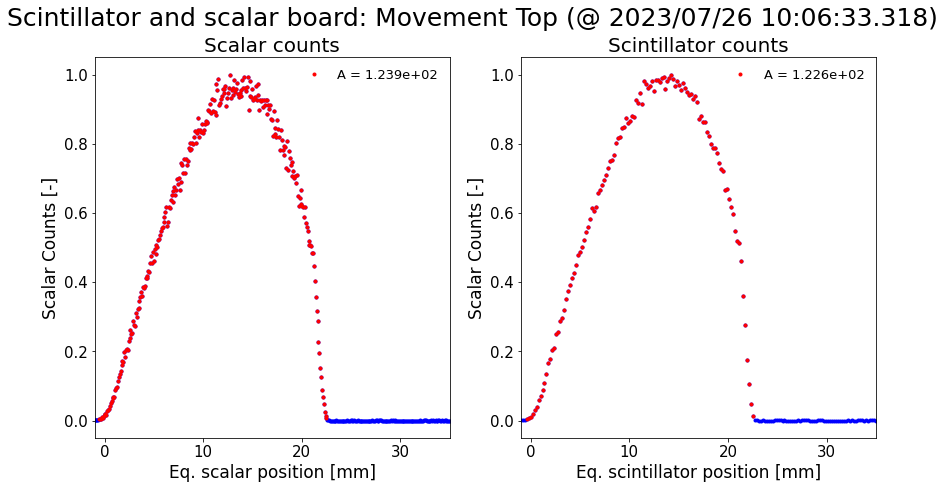

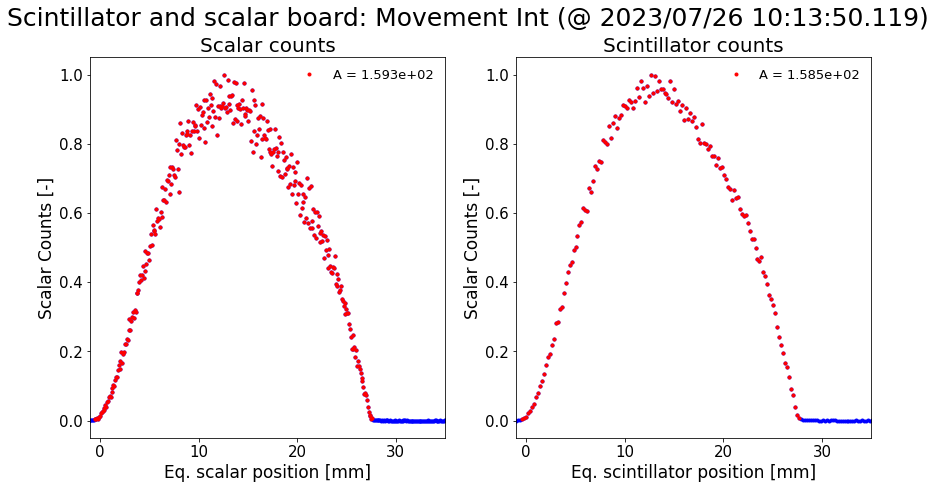

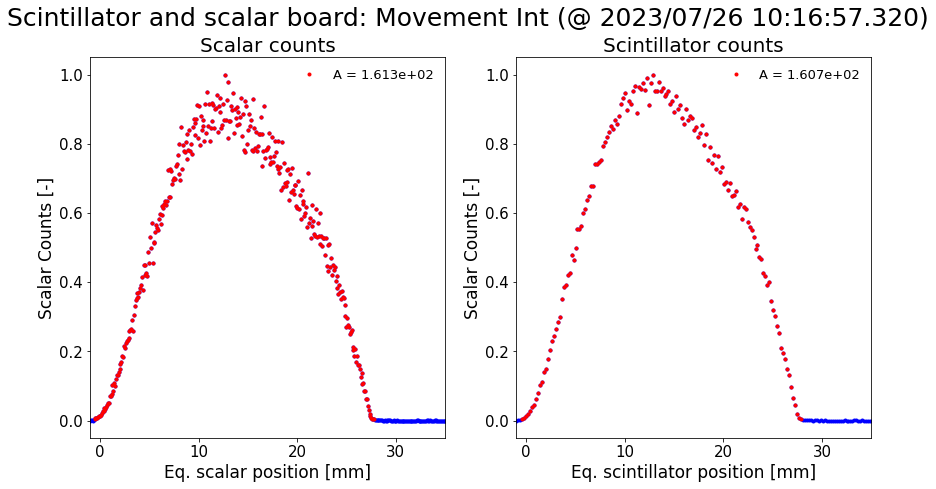

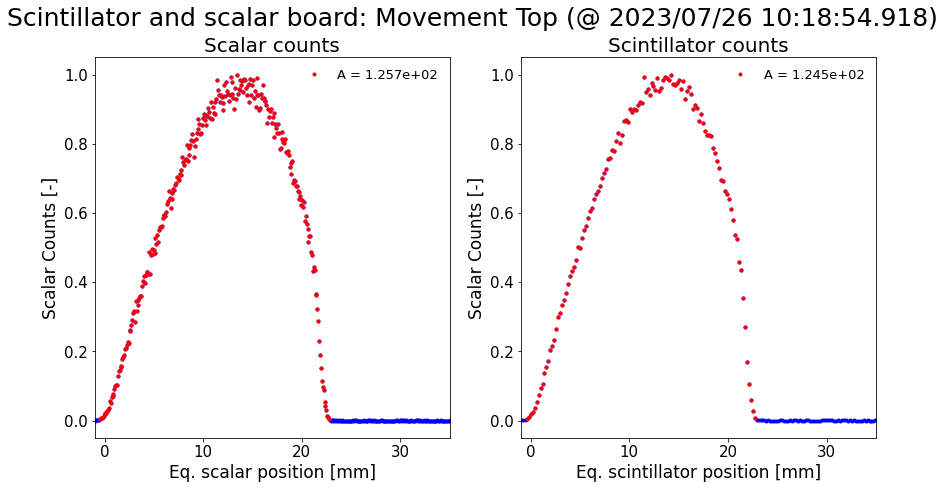

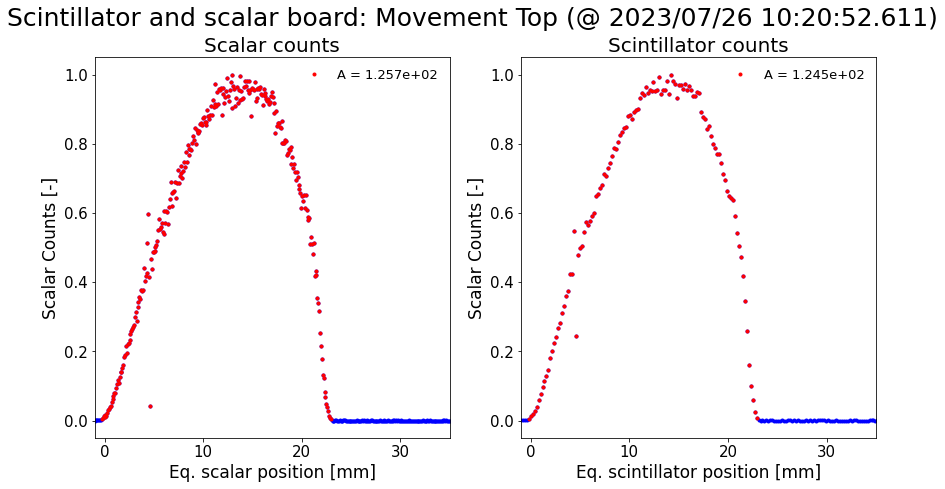

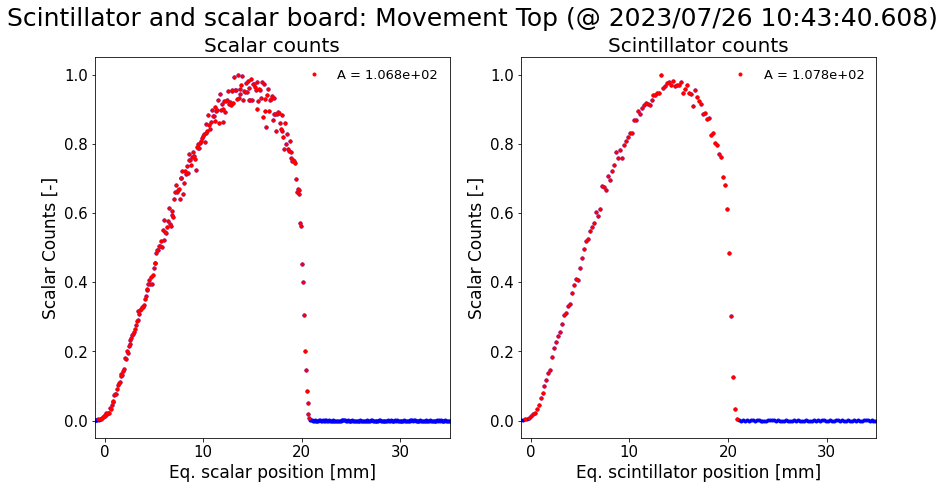

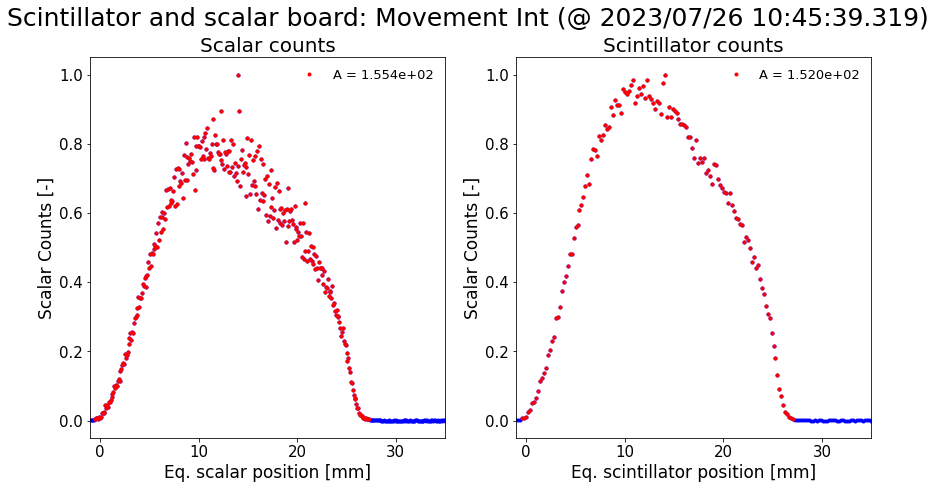

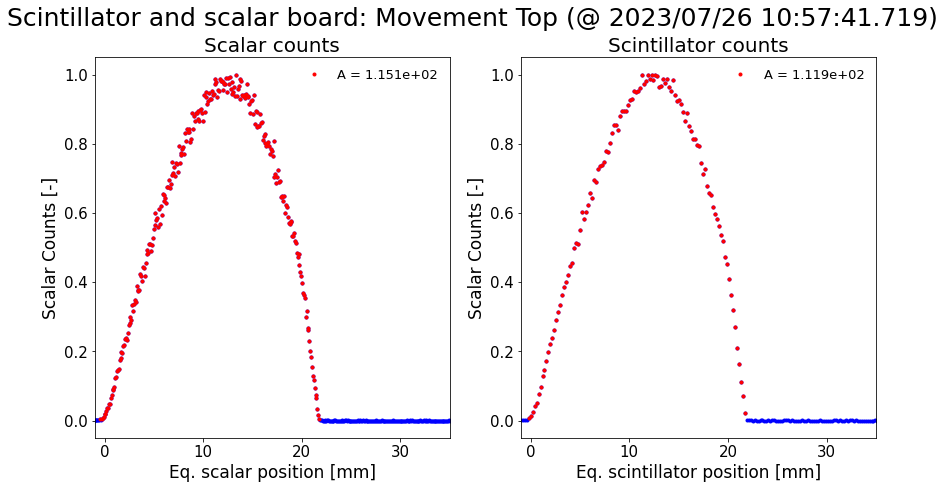

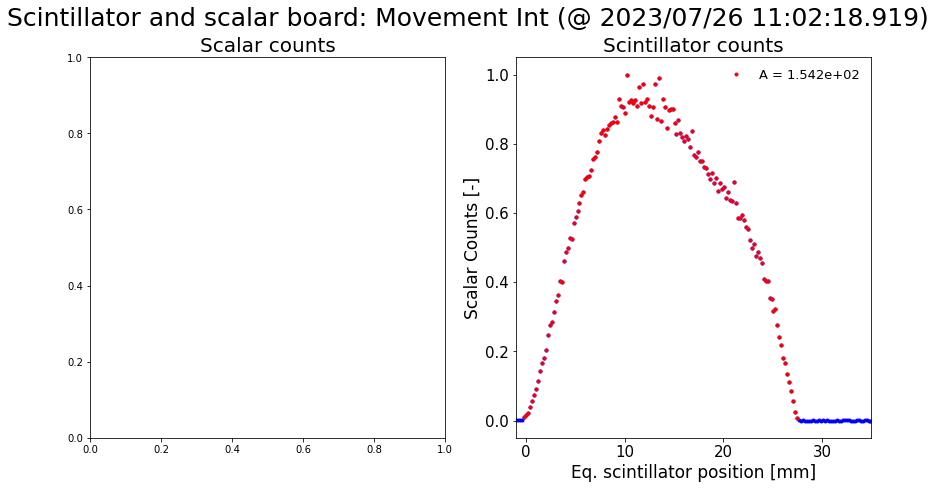

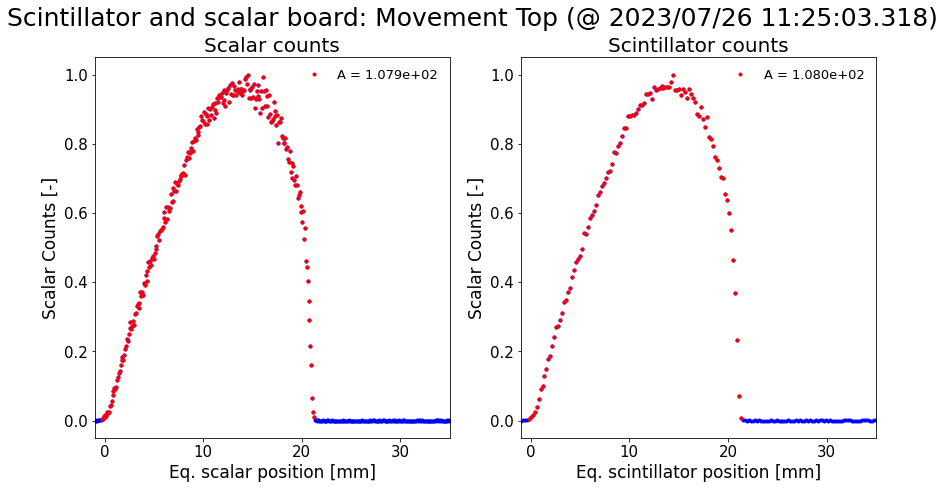

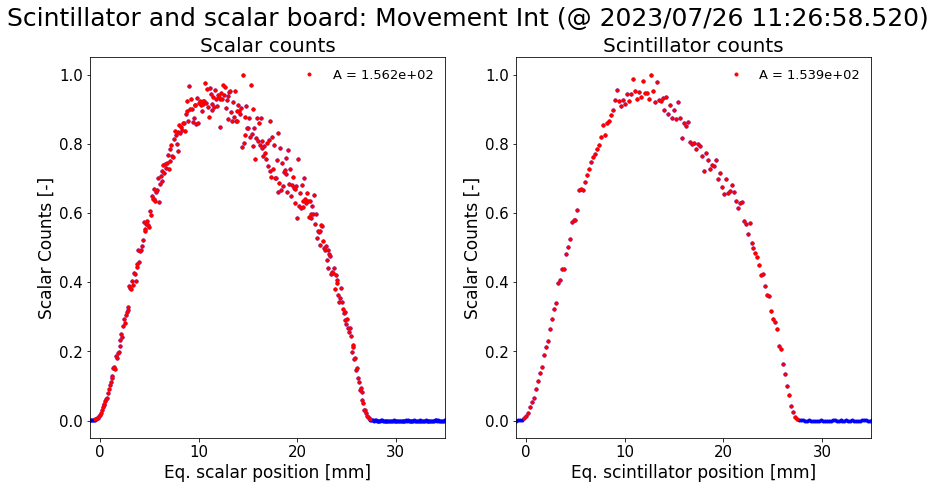

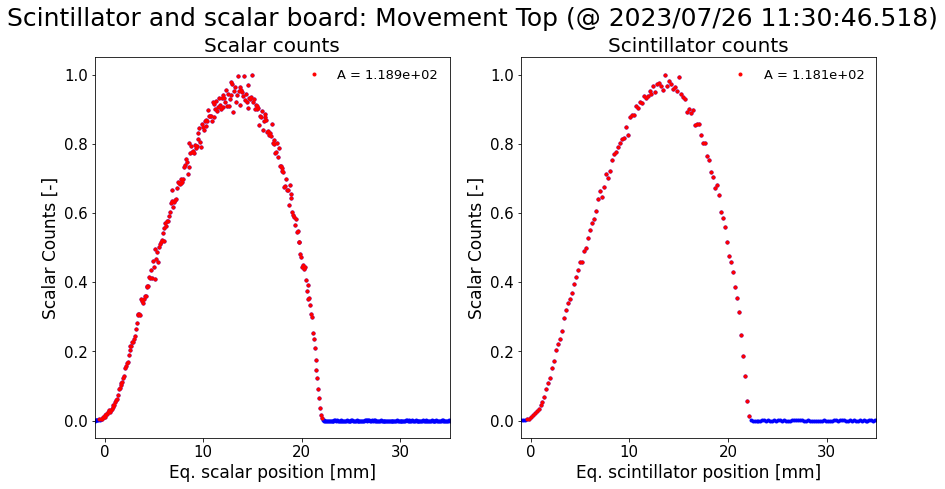

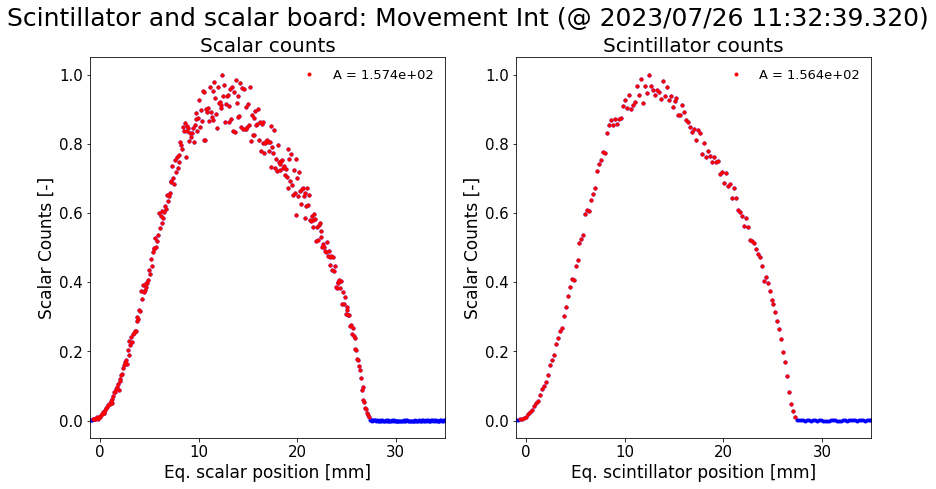

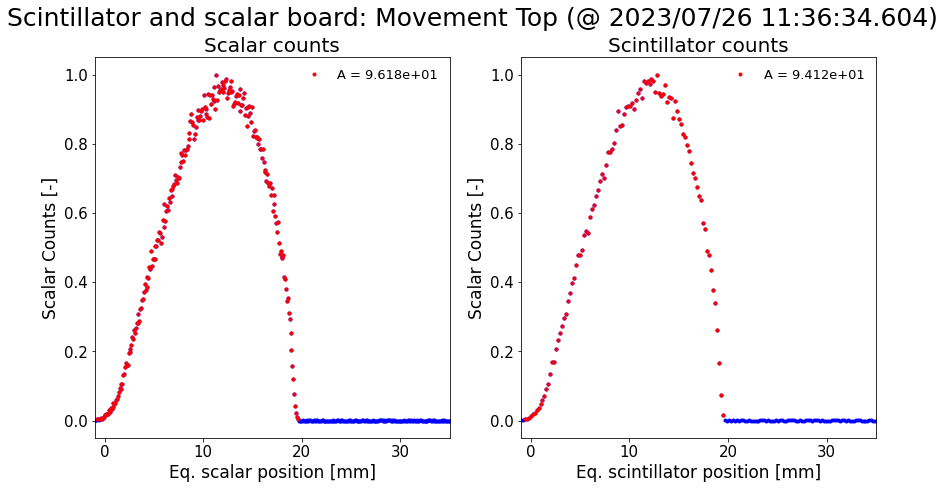

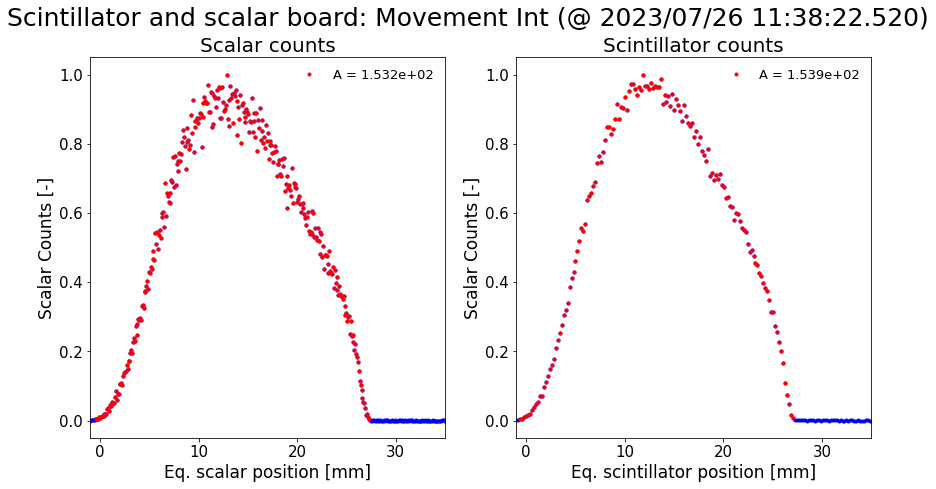

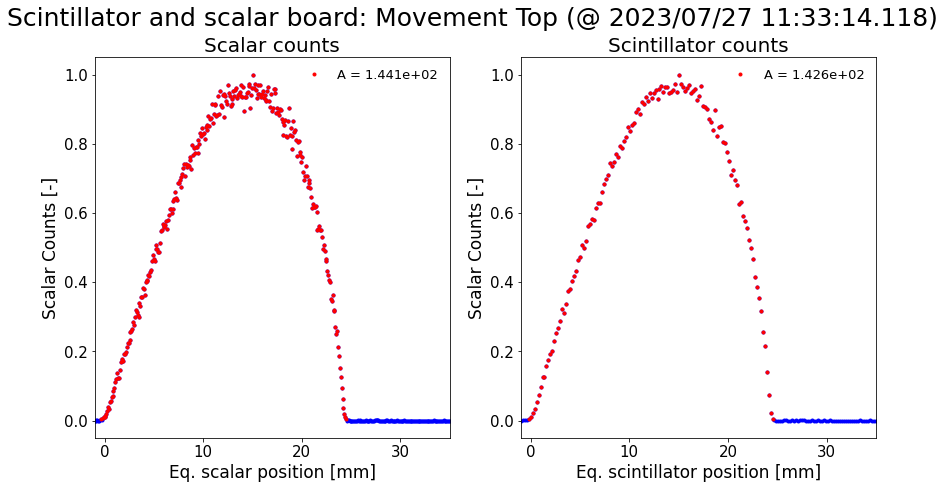

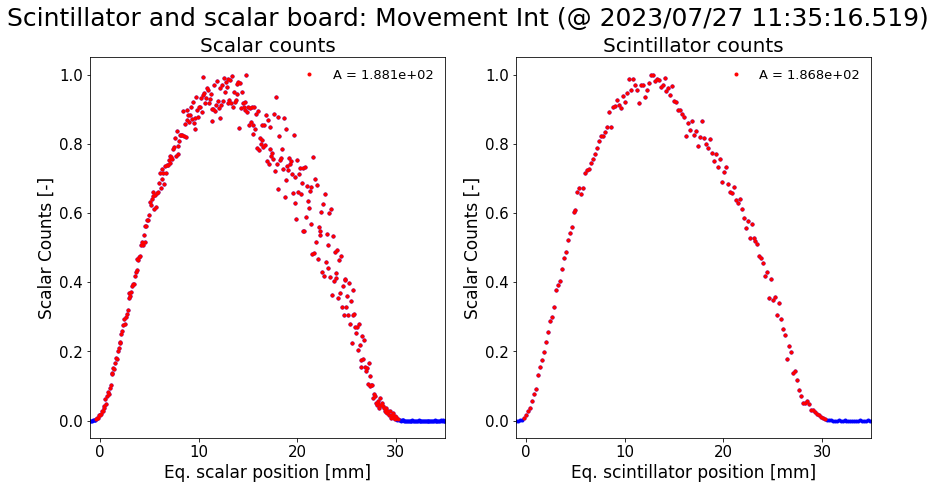

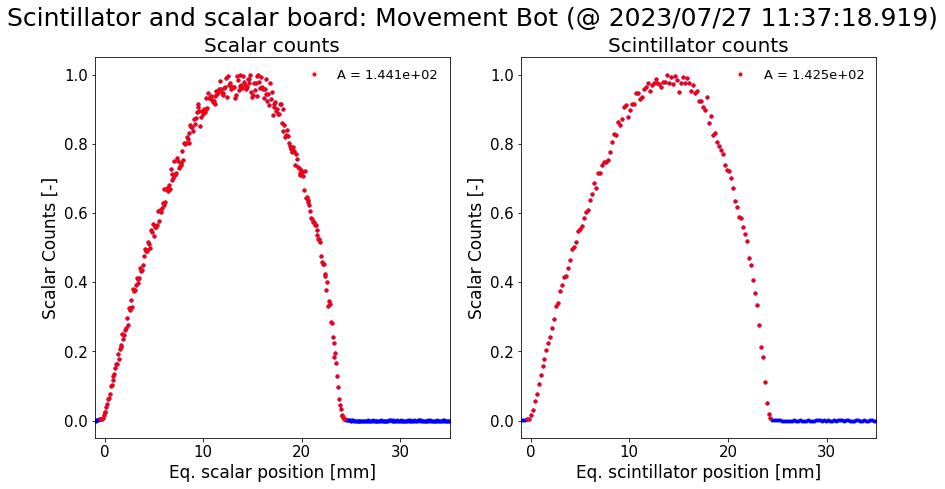

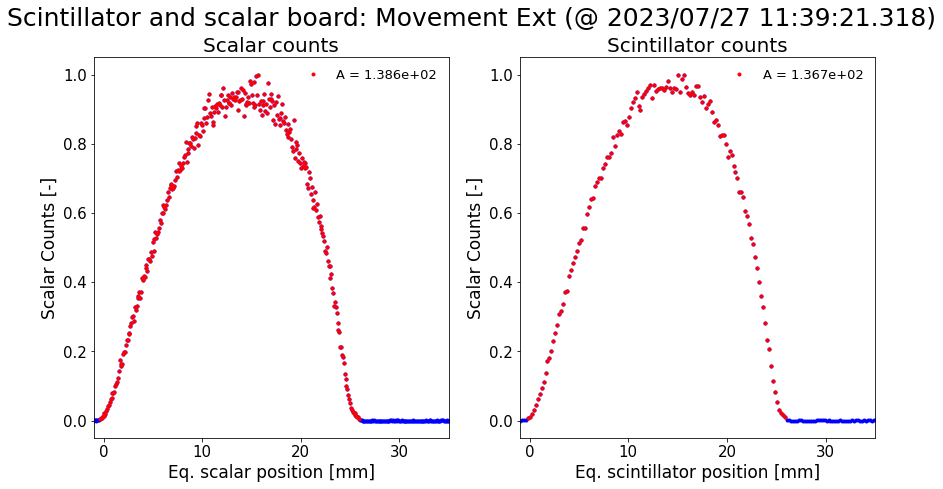

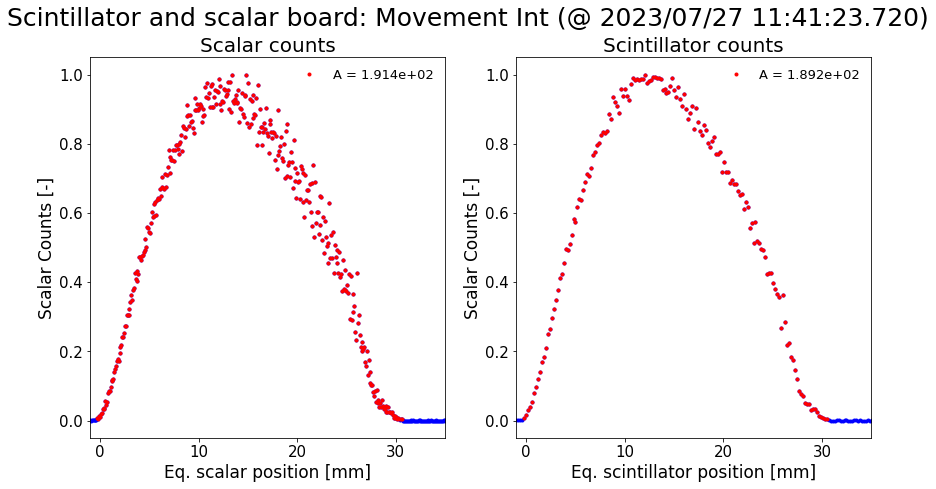

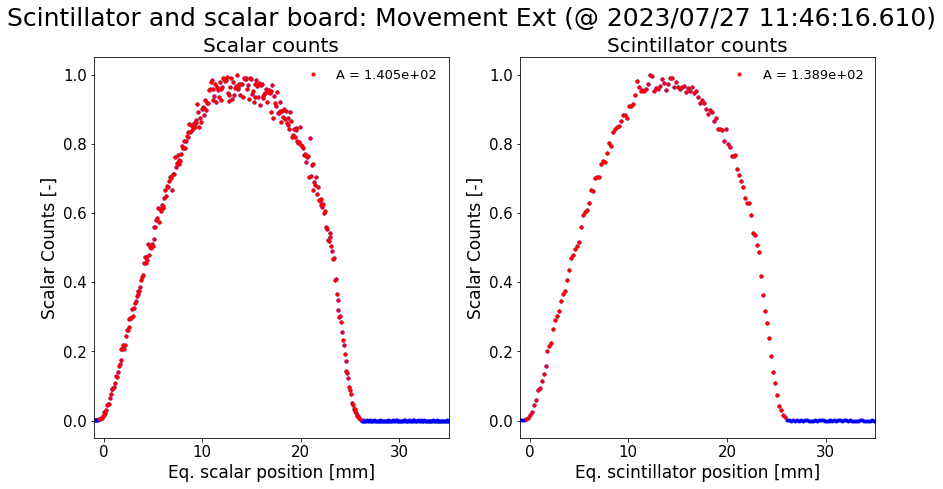

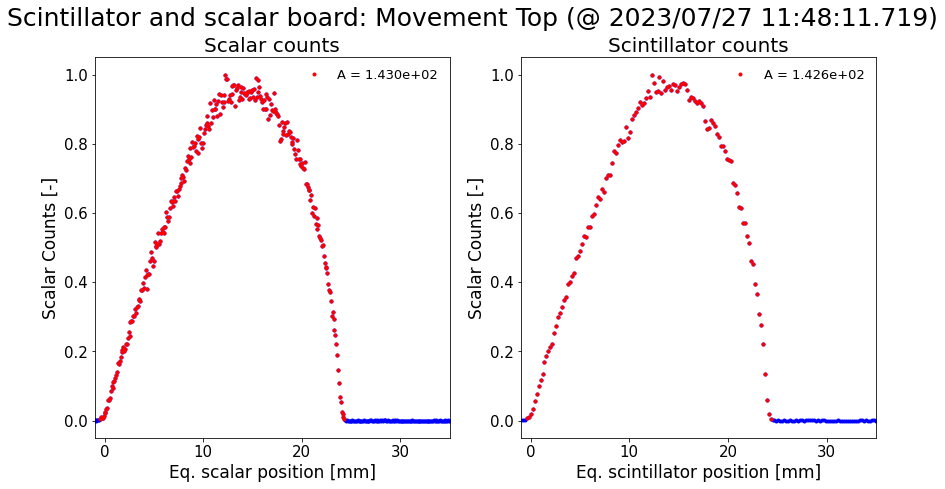

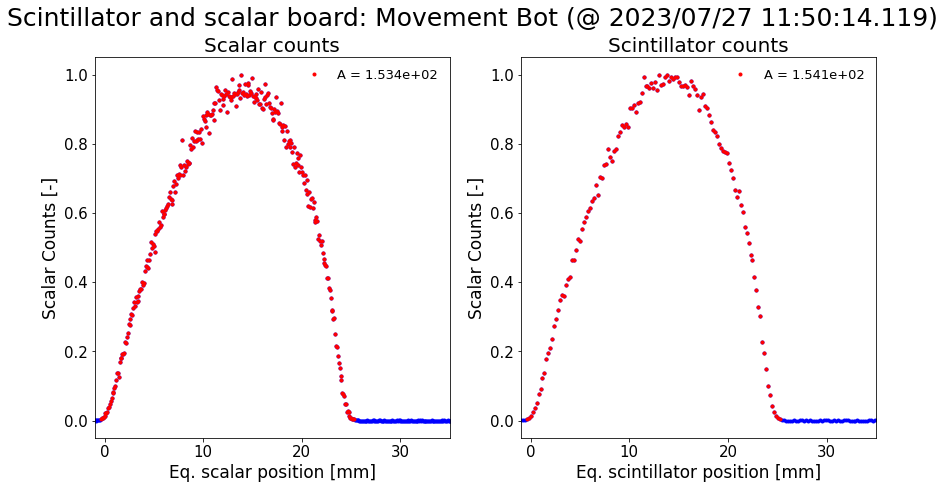

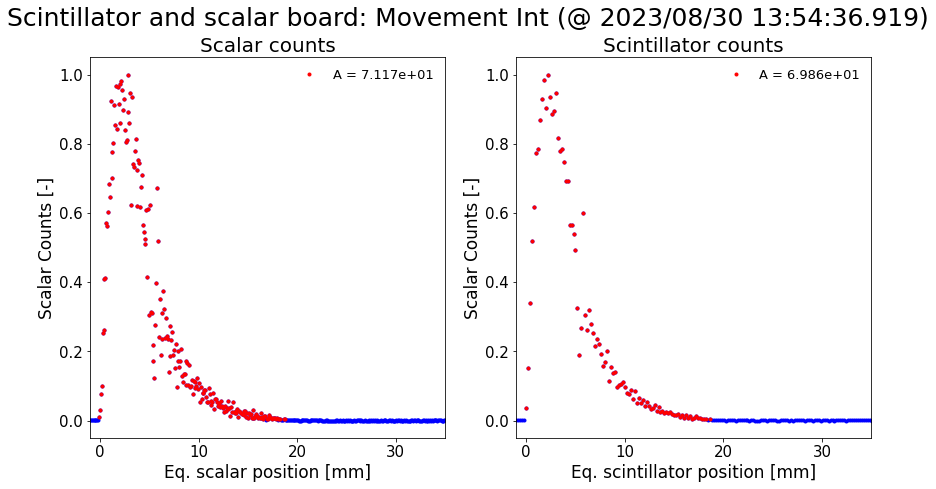

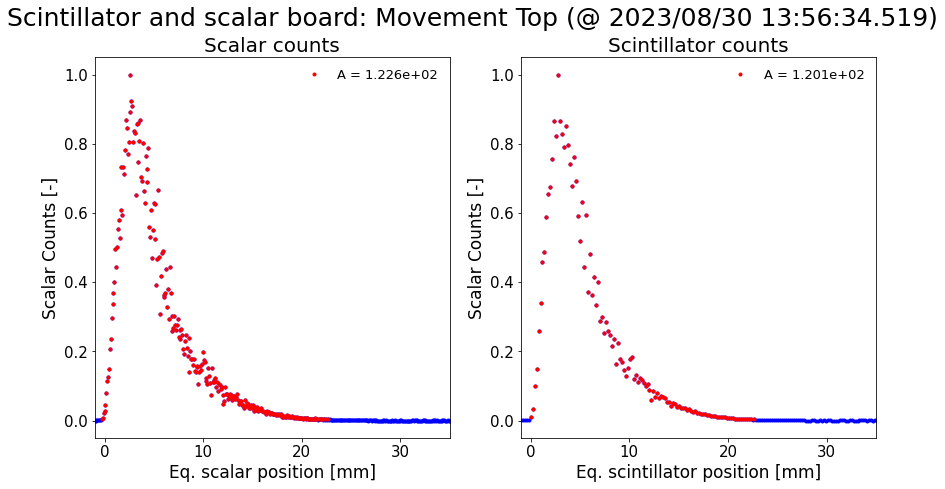

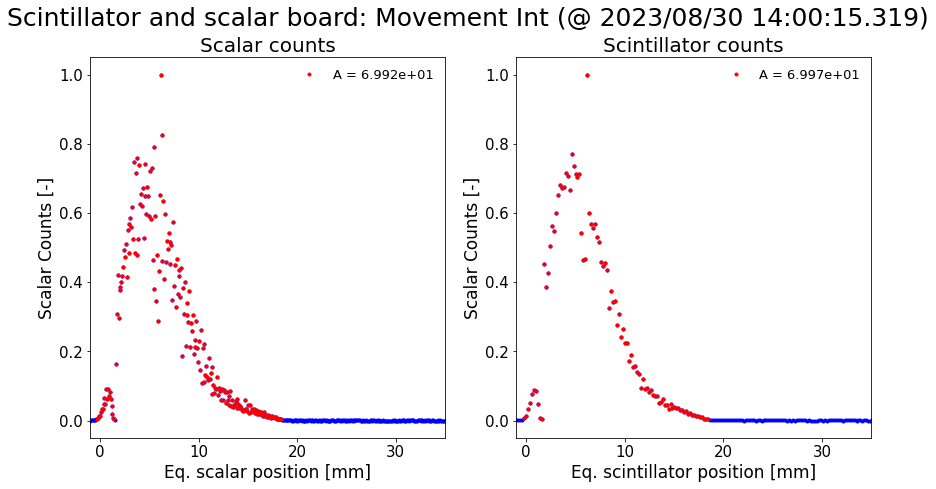

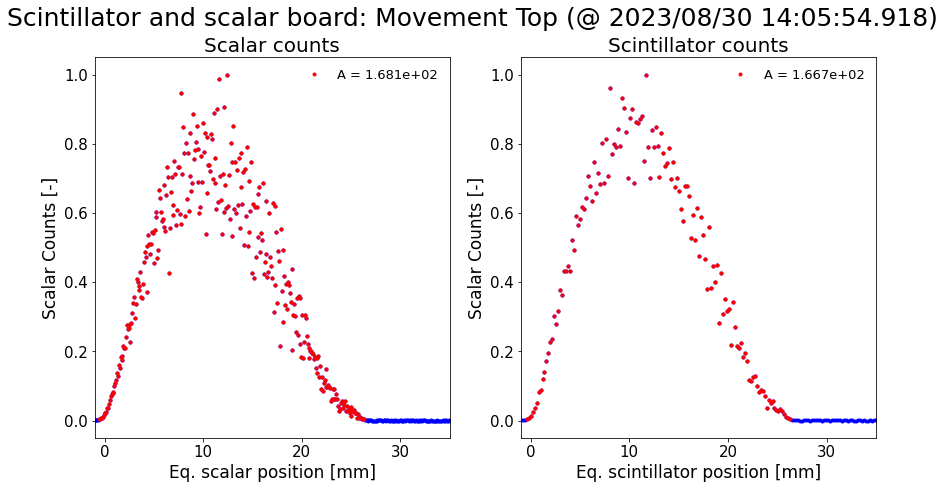

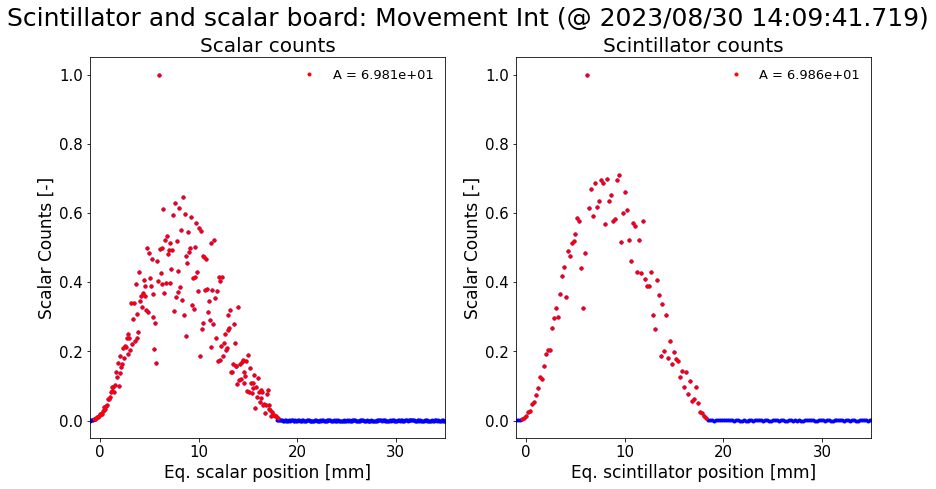

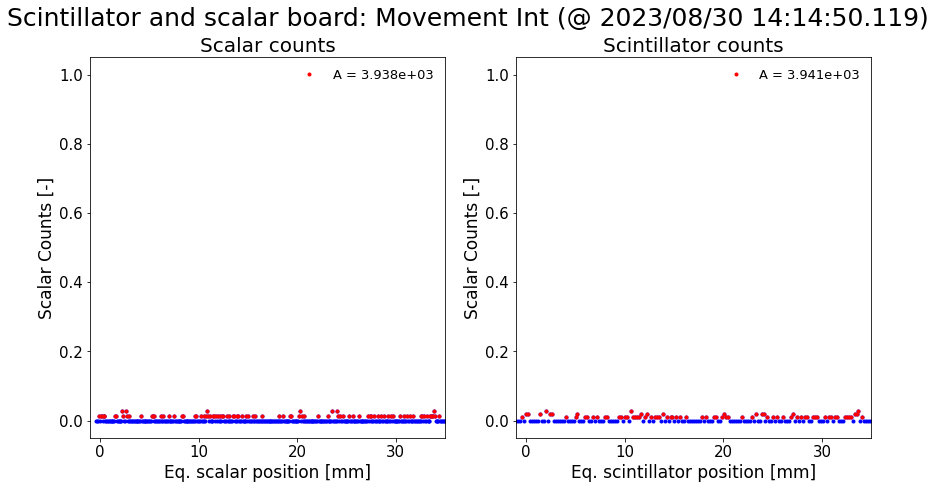

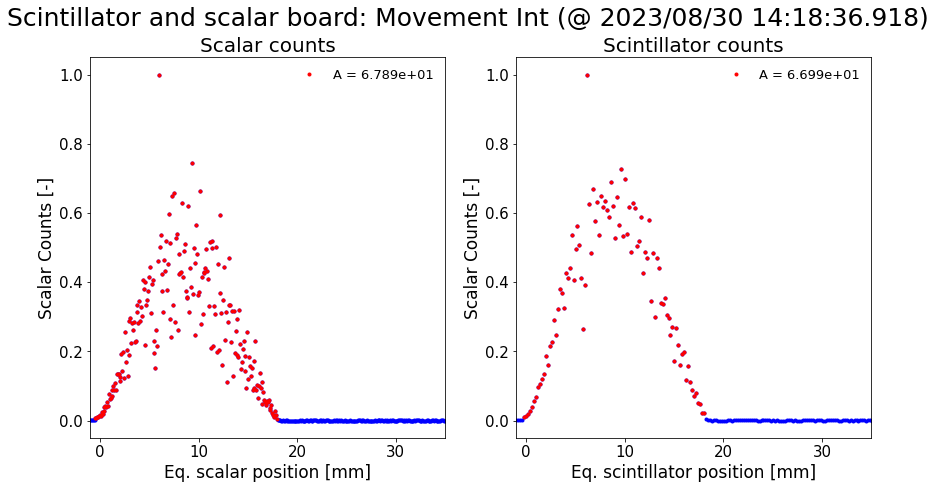

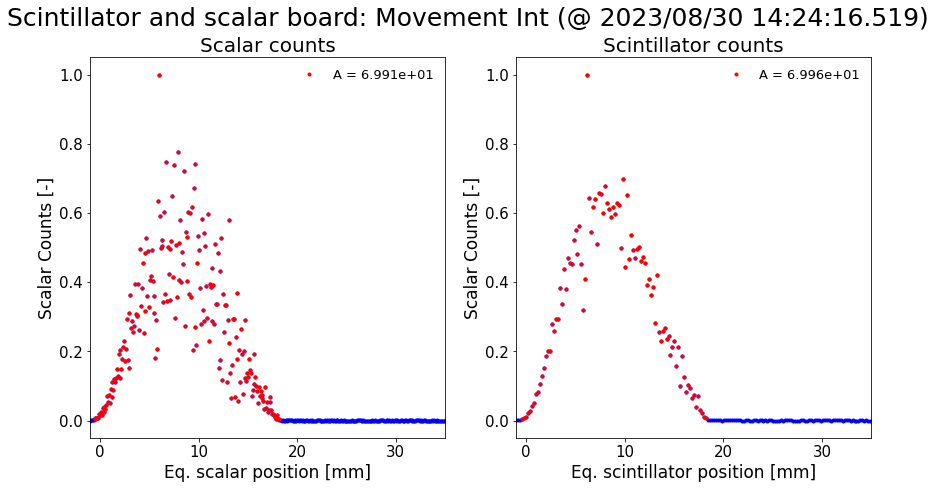

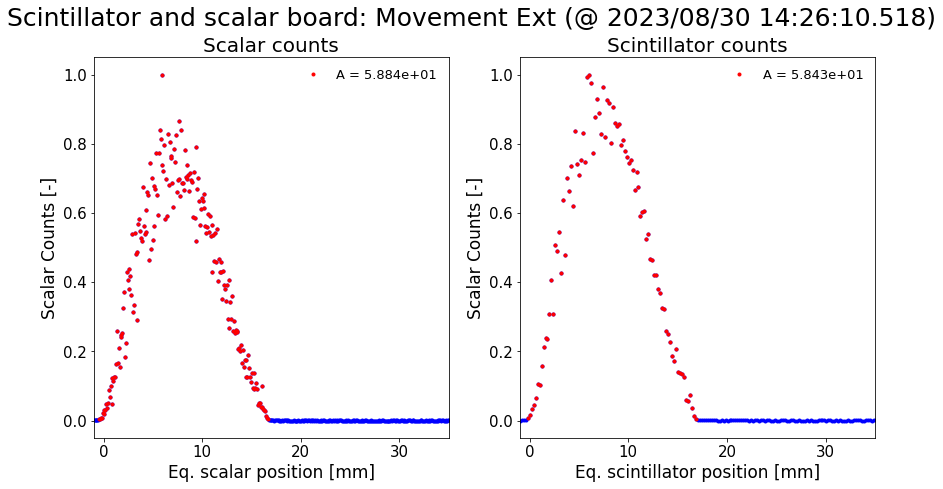

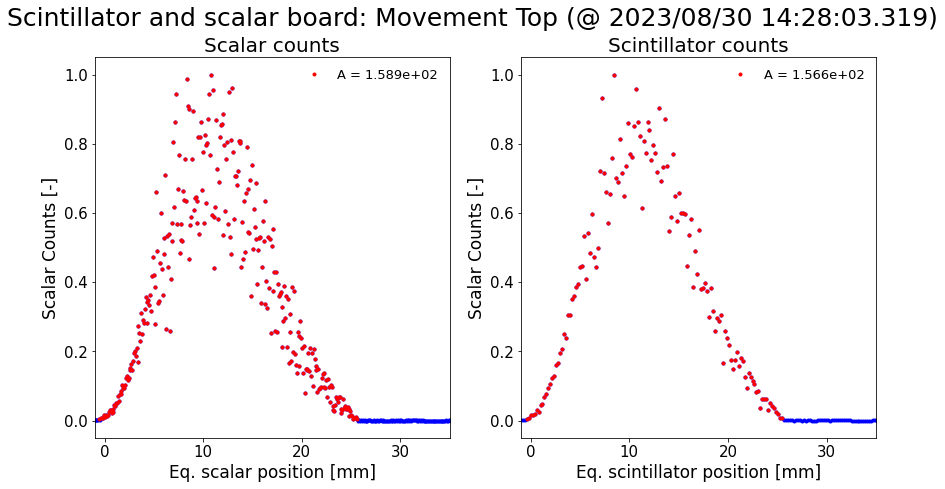

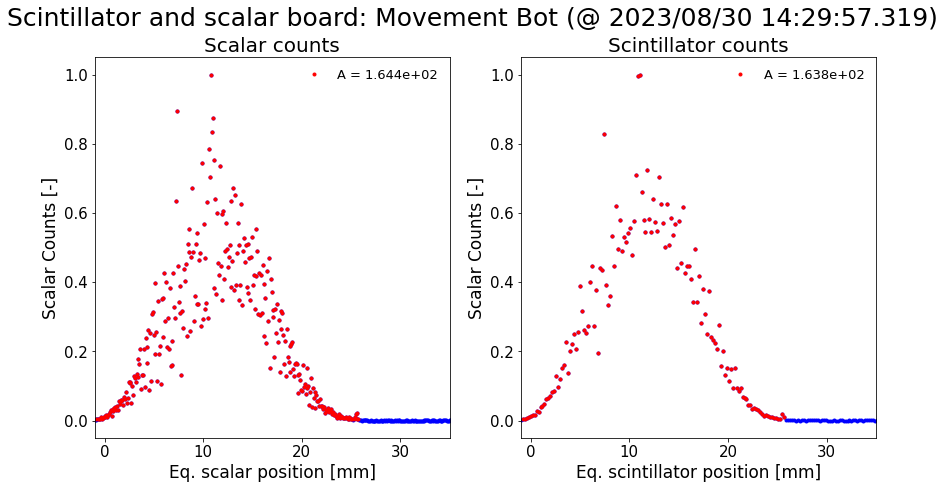

In [10]:
Acceptance_Scalar = []
Acceptance_Scintillator = []

for h in range(len(df.originUtcTime.values)):
    
    f, ax = plt.subplots(1, 2, figsize = (14, 7), sharex = False, sharey = False)
    f.suptitle("Scintillator and scalar board: Movement %s (@ %s)"%(df.scraperDirection.iloc[h], df.dataScraperOriginTime.iloc[h]), size = 25)
    
    if (df.scraperDirection.iloc[h] == "Bot") or (df.scraperDirection.iloc[h] == "Top"):
        beta_scraper = 4.288
        ScraperLossesFit = ScraperLosses_V
        GaussFit = Gauss_Fit_V
    else:
        beta_scraper = 4.975
        ScraperLossesFit = ScraperLosses_H
        GaussFit = Gauss_Fit_H
    
    ScraperStart = np.where(np.diff(np.array(df.scraperY.iloc[h]))<-0.03)[0][0]
    ScraperEnd = np.where(np.diff(np.array(df.scraperY.iloc[h]))<-0.03)[0][-1]

    delta_time_scraper = np.abs(df.scraperXms.iloc[h][ScraperStart] - df.scraperXms.iloc[h][ScraperEnd] )

    VelocityScraper = (max(df.scraperY.iloc[h]) - min(df.scraperY.iloc[h])) / delta_time_scraper
    
    #################################################    scalar plot     #################################################
    ax[0].set_title("Scalar counts", size = 20)

    ydata_scalar = np.array(df["det3.yval"].iloc[h][0])[::-1]
    xdata_scalar = np.array(df["det3.xms"].iloc[h]) * VelocityScraper
    
    ind = np.where(ydata_scalar/max(ydata_scalar)>0.003)[0]
    limit = 0.01
    
    ind_minlosses = np.where(ydata_scalar/max(ydata_scalar)>limit)[0][0]+1
    if np.mean(ydata_scalar)>1:
        
        ind = np.where(ydata_scalar/max(ydata_scalar)>0.003)[0]
        
        ax[0].plot( xdata_scalar-xdata_scalar[ind_minlosses], ydata_scalar/max(ydata_scalar), ".b" )
        ax[0].plot( xdata_scalar[ind]-xdata_scalar[ind_minlosses], ydata_scalar[ind]/max(ydata_scalar), ".r", label = "A = %1.3e"%((xdata_scalar[ind[-1]]-xdata_scalar[ind[0]])**2/beta_scraper))

        Acceptance_Scalar = np.append(Acceptance_Scalar, (xdata_scalar[ind[-1]]-xdata_scalar[ind[0]])**2/beta_scraper)
        ax[0].set_xlabel("Eq. scalar position [mm]", size = 17)
        ax[0].set_ylabel("Scalar Counts [-]", size = 17)
        ax[0].tick_params(axis = "both", which = "major", labelsize = 15)
        ax[0].legend(prop = {"size":13}, frameon = False)
        ax[0].set_xlim([-1, 35])
    else:
        Acceptance_Scalar = np.append(Acceptance_Scalar, np.nan)

        
#     #################################################    scintillator plot     #################################################
    ax[1].set_title("Scintillator counts", size = 20)
    xdata_scint = np.array(df["det1.xms"].iloc[h])*VelocityScraper
    ydata_scint = np.array(df["det1.yval"].iloc[h][0])[::-1]
    ind_minlosses = np.where(ydata_scint/max(ydata_scint)>limit)[0][0]
    
    ind = np.where(ydata_scint/max(ydata_scint)>0.003)[0]
    
    ax[1].plot( xdata_scint - xdata_scint[ind_minlosses], ydata_scint/max(ydata_scint), ".b" )
    ax[1].plot( xdata_scint [ind] - xdata_scint[ind_minlosses], ydata_scint[ind]/max(ydata_scint), ".r", label = "A = %1.3e"%((xdata_scint[ind[-1]]-xdata_scint[ind[0]])**2/beta_scraper ))

    Acceptance_Scintillator = np.append(Acceptance_Scintillator, (xdata_scint[ind[-1]]-xdata_scint[ind[0]])**2/beta_scraper)
    
    ax[1].set_xlabel("Eq. scintillator position [mm]", size = 17)
    ax[1].set_ylabel("Scalar Counts [-]", size = 17)
    ax[1].tick_params(axis = "both", which = "major", labelsize = 15)
    ax[1].legend(prop = {"size":13}, frameon = False)
    ax[1].set_xlim([-1, 35])

In [11]:
df["AcceptanceScalar"] = Acceptance_Scalar
df["AcceptanceScintillator"] = Acceptance_Scintillator

# Compute acceptance with fit and reconstructing Gaussian profile

Valid, all the needed variables have been inserted
First non-zero point in losses 0
Valid, all the needed variables have been inserted
First non-zero point in losses 1
Valid, all the needed variables have been inserted
First non-zero point in losses 0
Valid, all the needed variables have been inserted
First non-zero point in losses 1
Valid, all the needed variables have been inserted
First non-zero point in losses 0
Valid, all the needed variables have been inserted
First non-zero point in losses 1
Valid, all the needed variables have been inserted
First non-zero point in losses 0
Valid, all the needed variables have been inserted
First non-zero point in losses 1
Valid, all the needed variables have been inserted
First non-zero point in losses 0
Valid, all the needed variables have been inserted
First non-zero point in losses 1
Valid, all the needed variables have been inserted
First non-zero point in losses 0
Valid, all the needed variables have been inserted
First non-zero point in l

/tmp/ipykernel_529/1751785668.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, 3, figsize = (20, 7), sharex = False, sharey = False)


Valid, all the needed variables have been inserted
First non-zero point in losses 0
Valid, all the needed variables have been inserted
First non-zero point in losses 1
Valid, all the needed variables have been inserted
First non-zero point in losses 1
Valid, all the needed variables have been inserted
First non-zero point in losses 0
Valid, all the needed variables have been inserted
First non-zero point in losses 1
Valid, all the needed variables have been inserted
First non-zero point in losses 0
Valid, all the needed variables have been inserted
First non-zero point in losses 1
Valid, all the needed variables have been inserted
First non-zero point in losses 0
Valid, all the needed variables have been inserted
First non-zero point in losses 1
Valid, all the needed variables have been inserted
First non-zero point in losses 0
Valid, all the needed variables have been inserted
First non-zero point in losses 1
Valid, all the needed variables have been inserted
First non-zero point in l

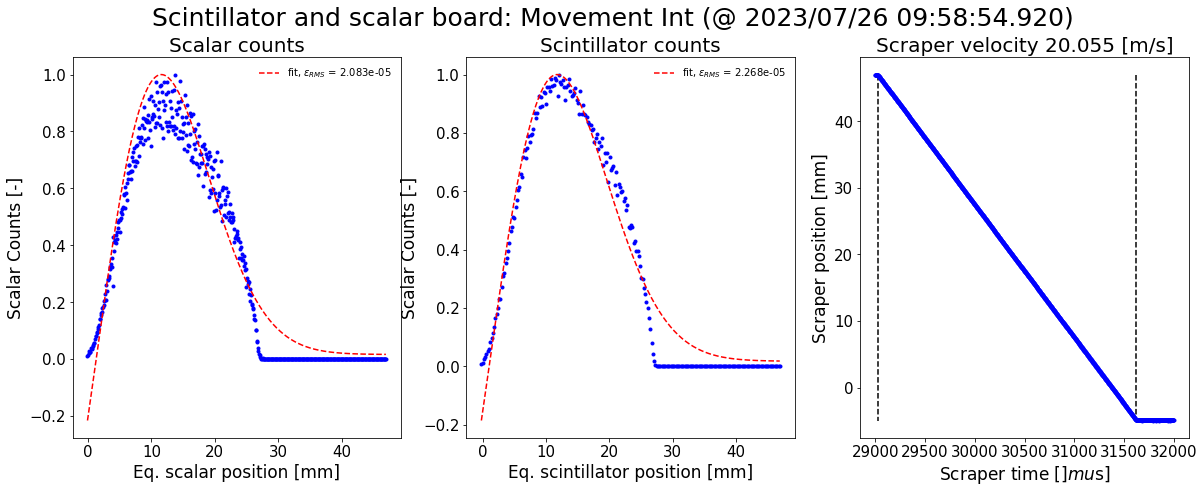

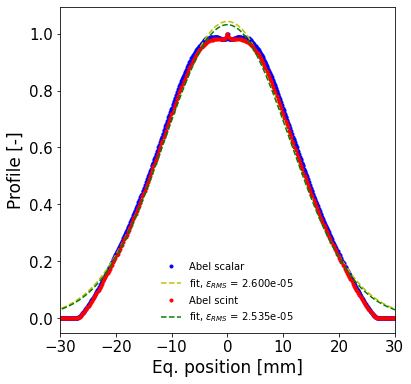

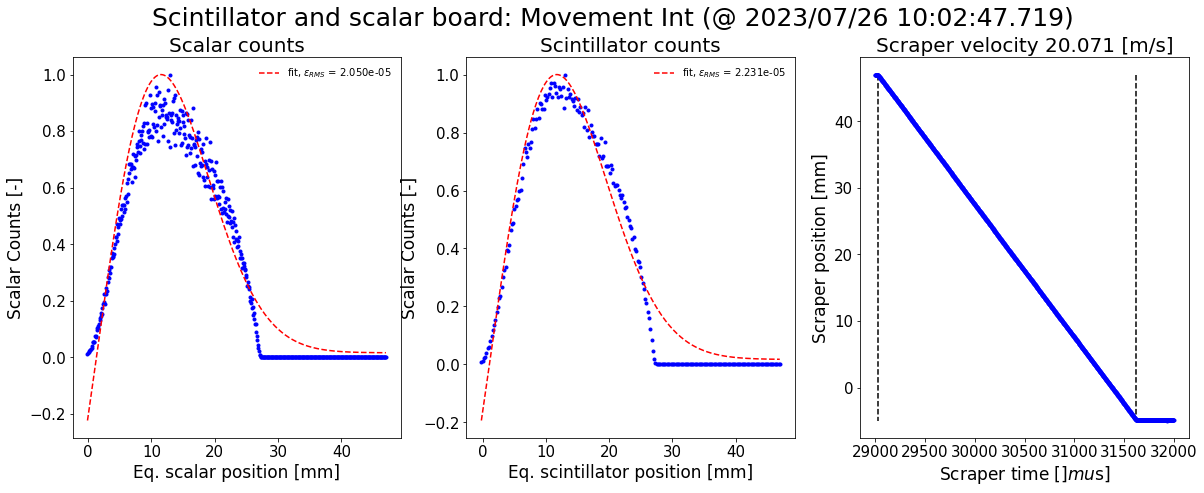

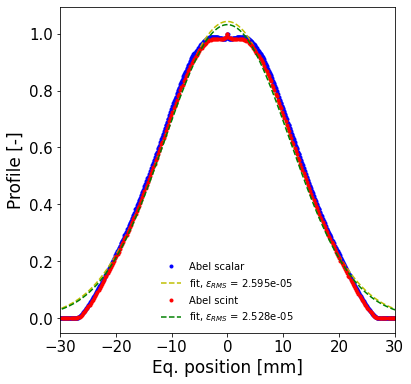

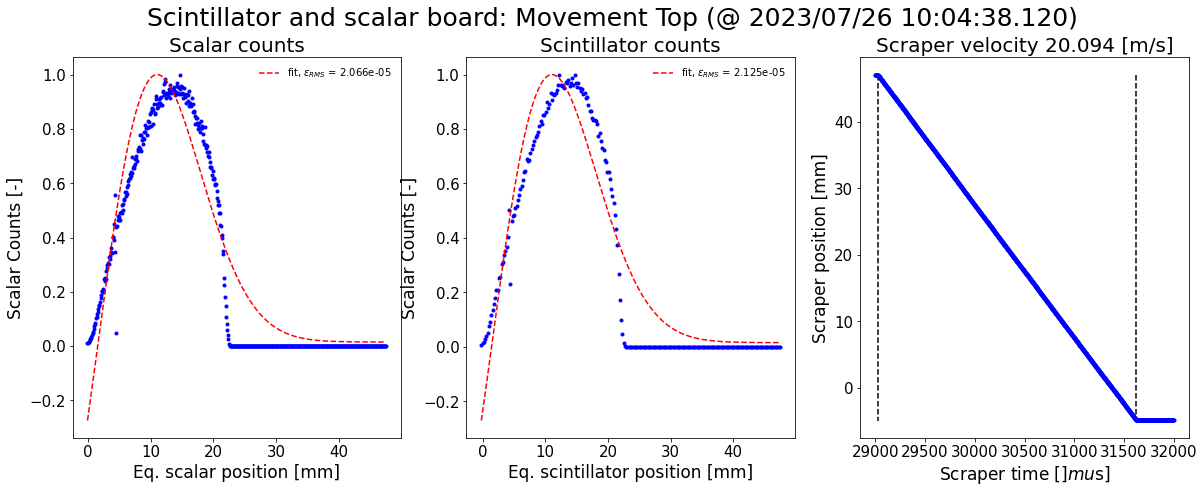

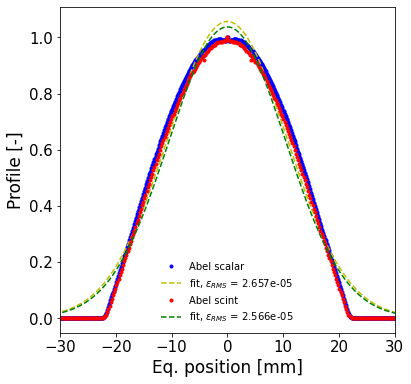

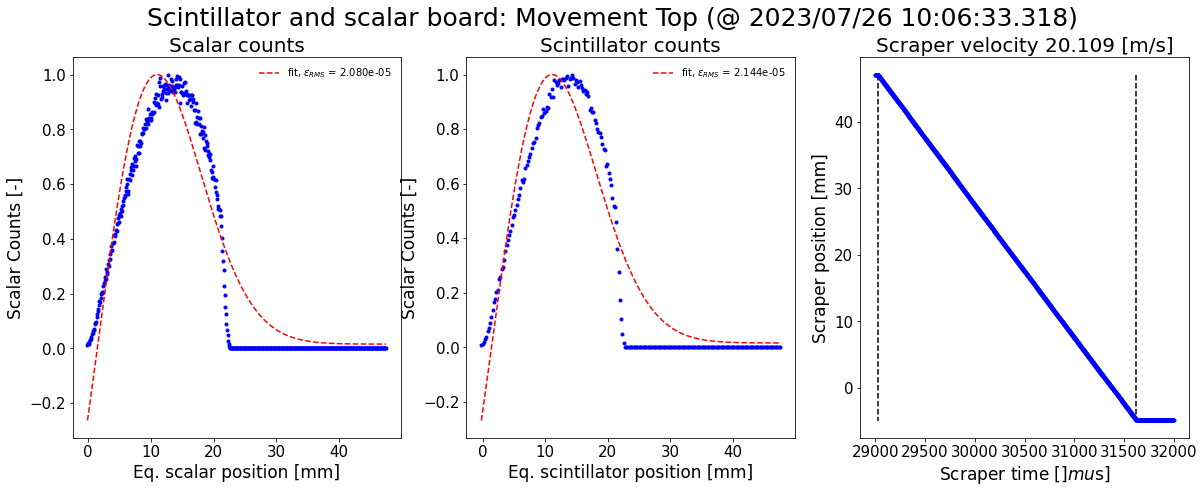

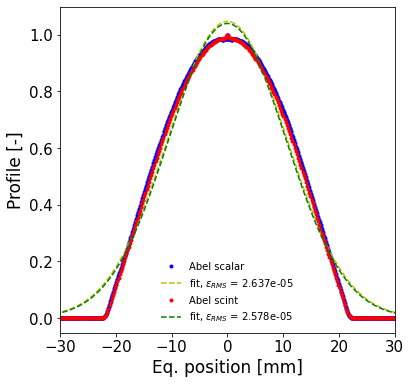

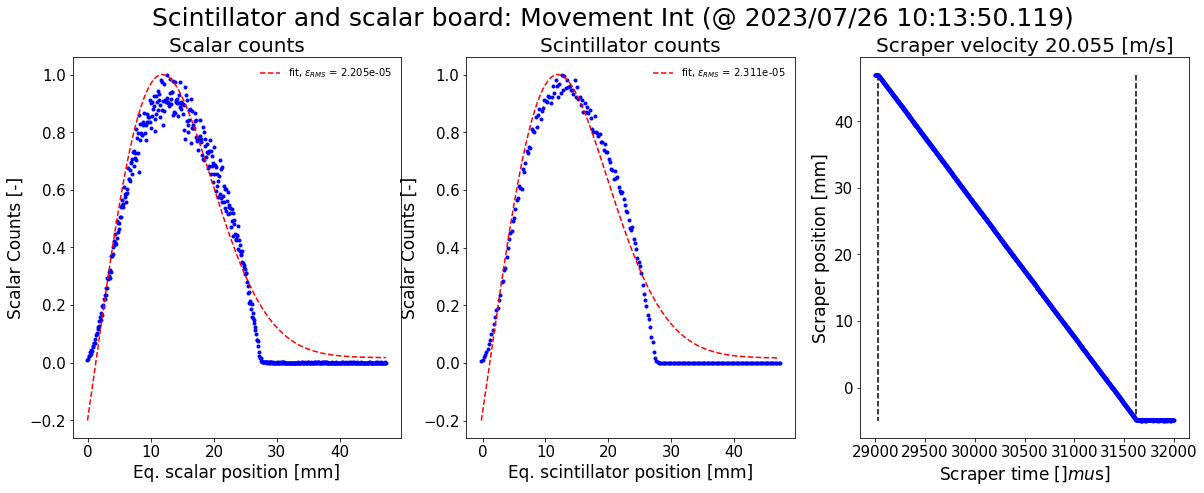

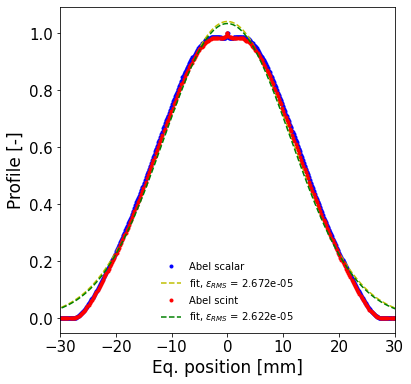

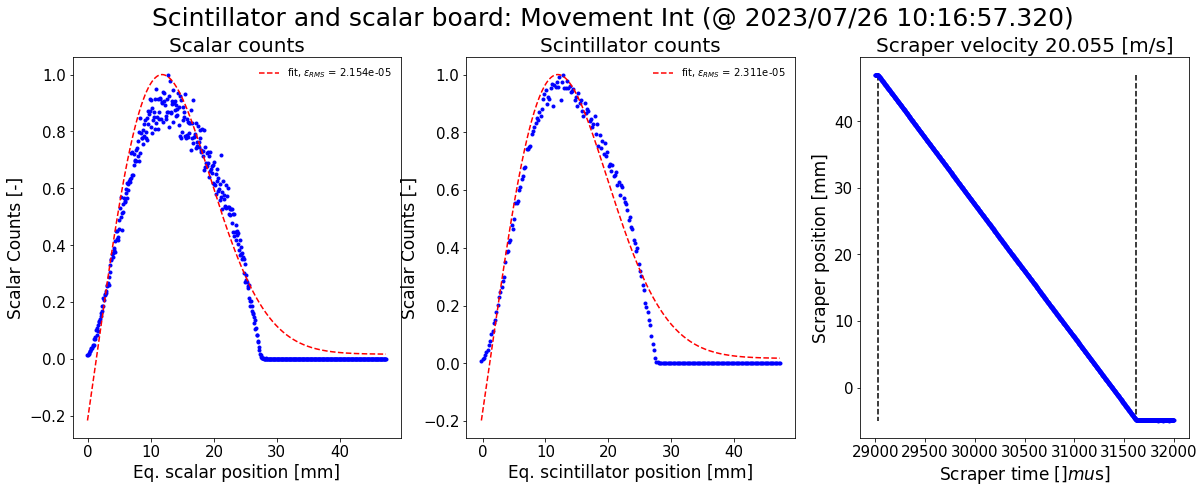

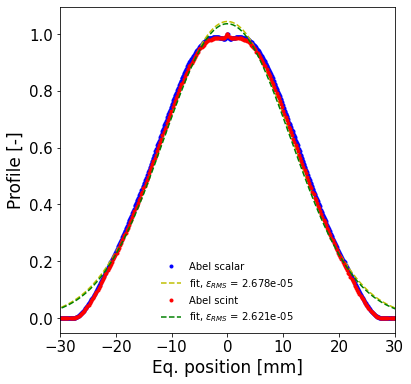

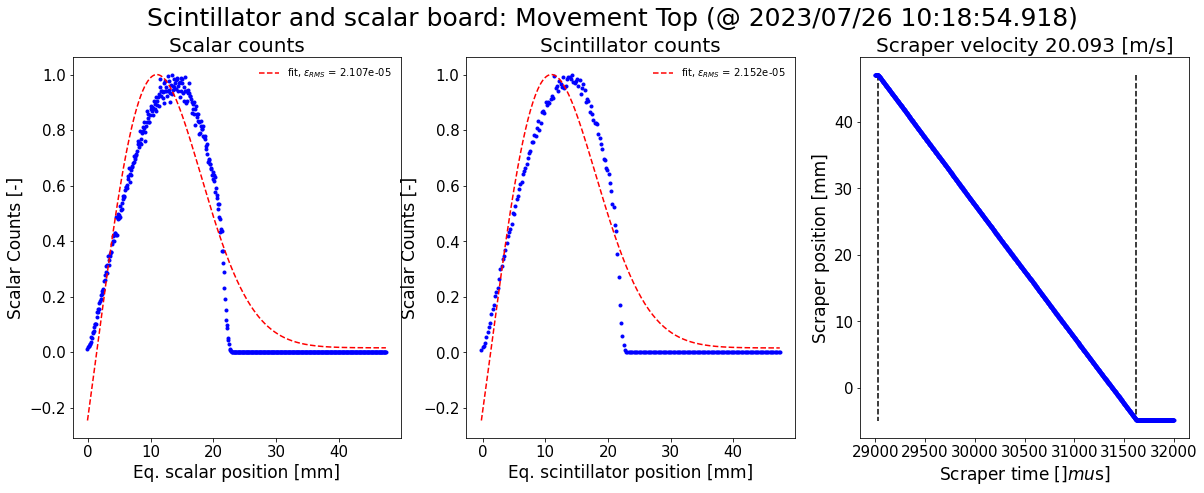

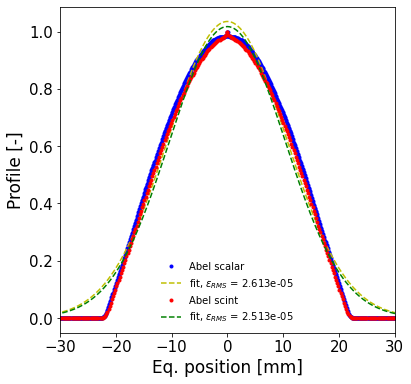

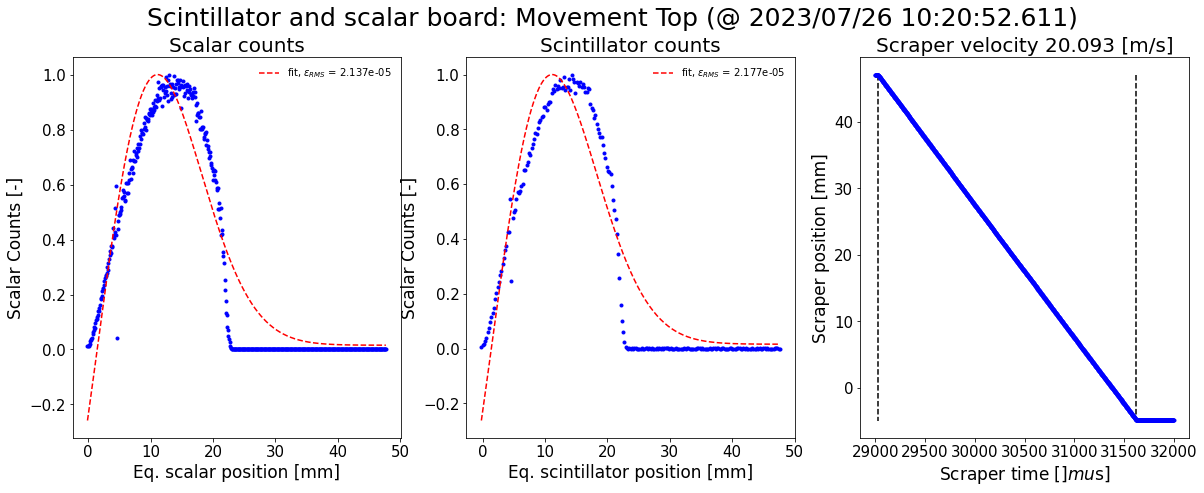

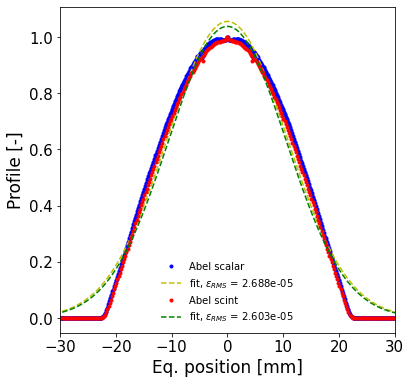

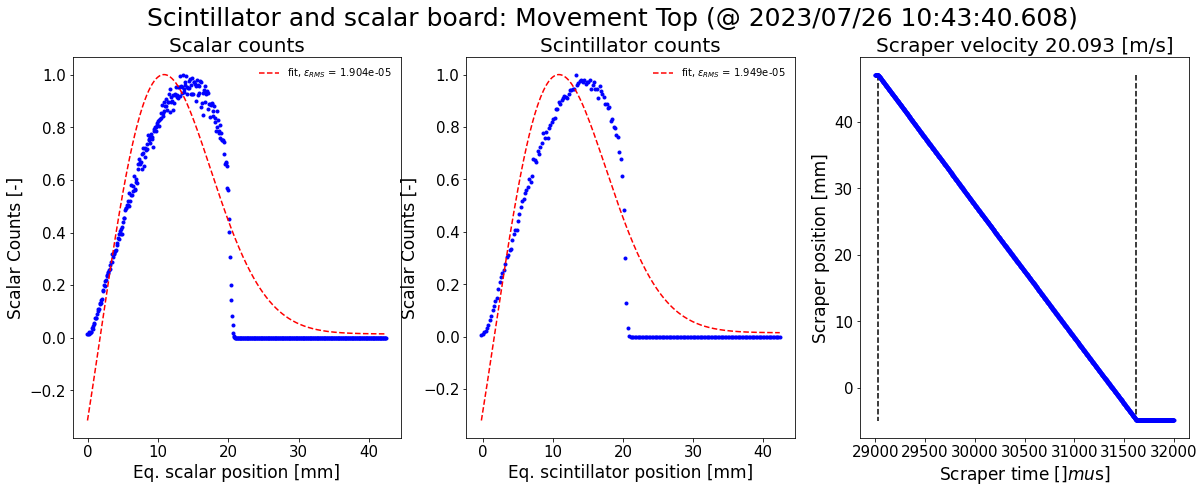

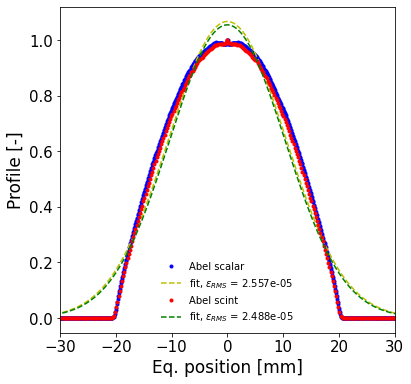

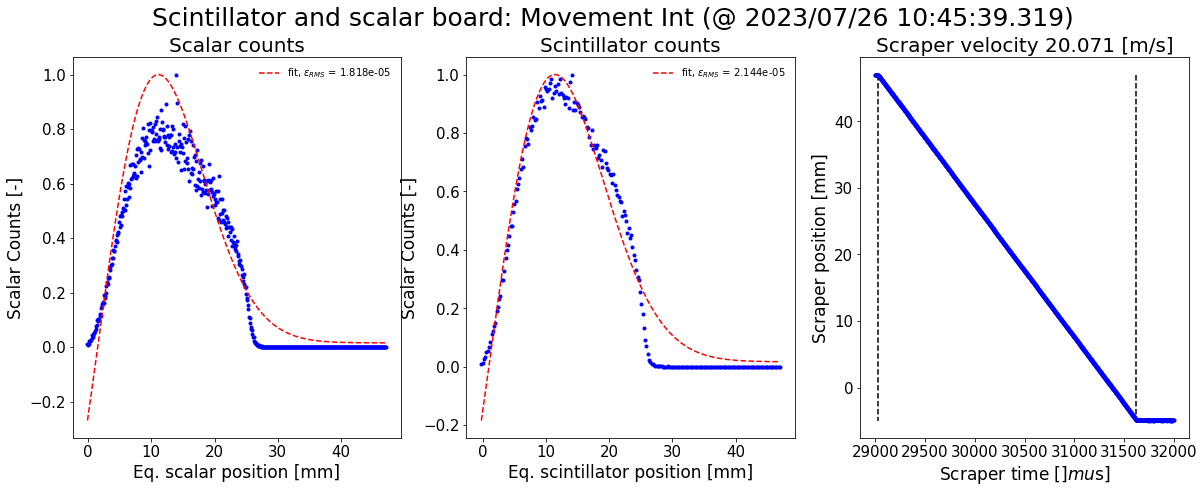

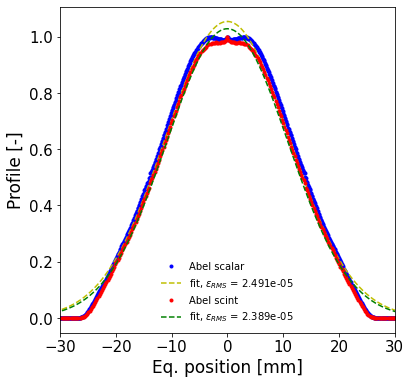

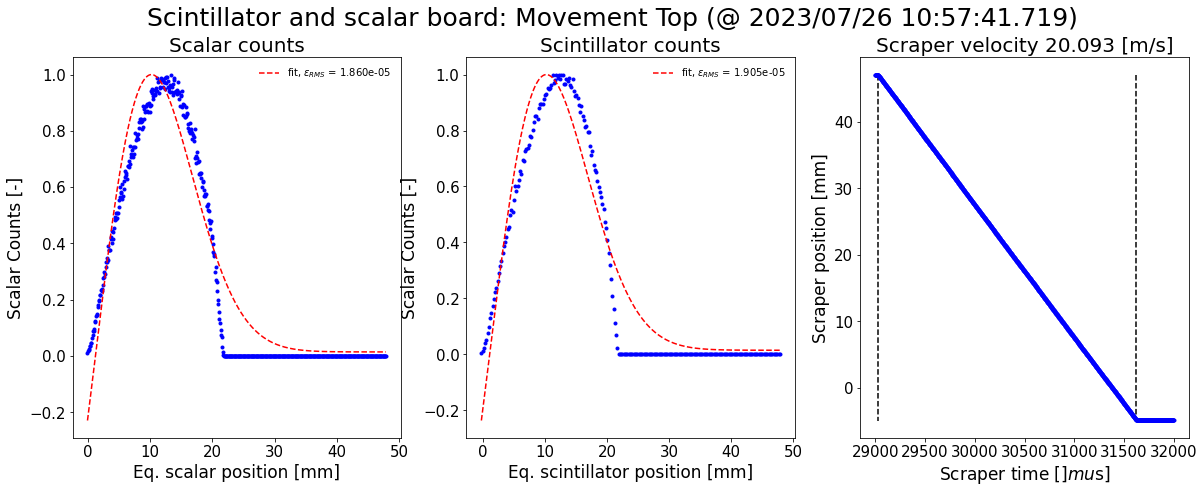

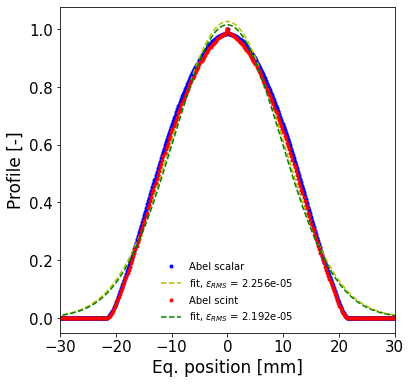

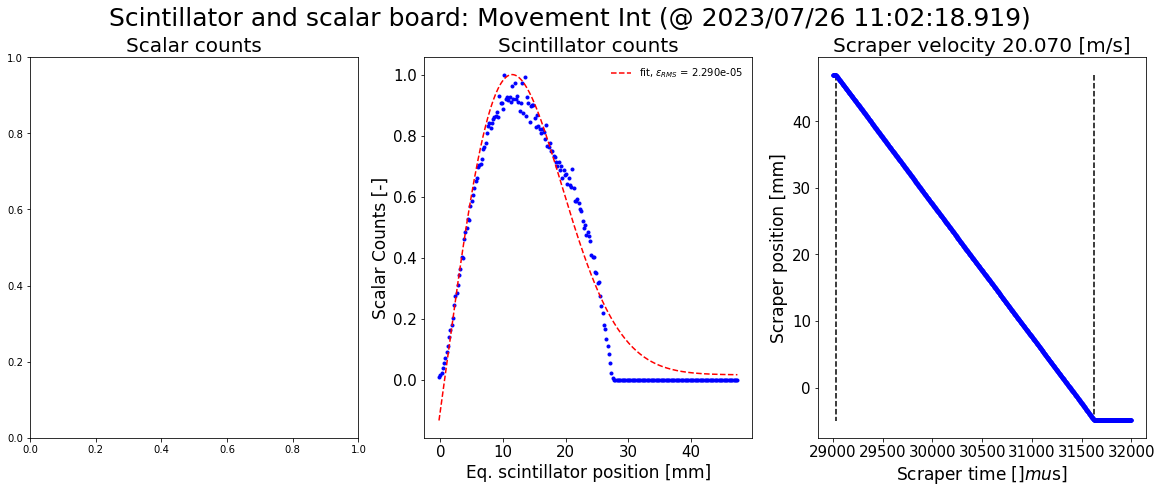

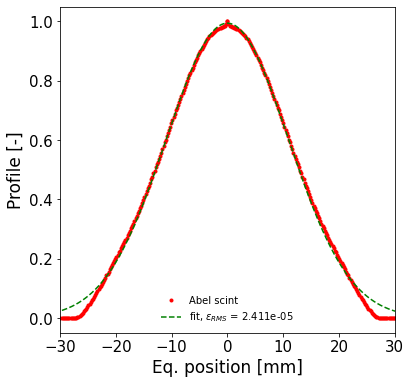

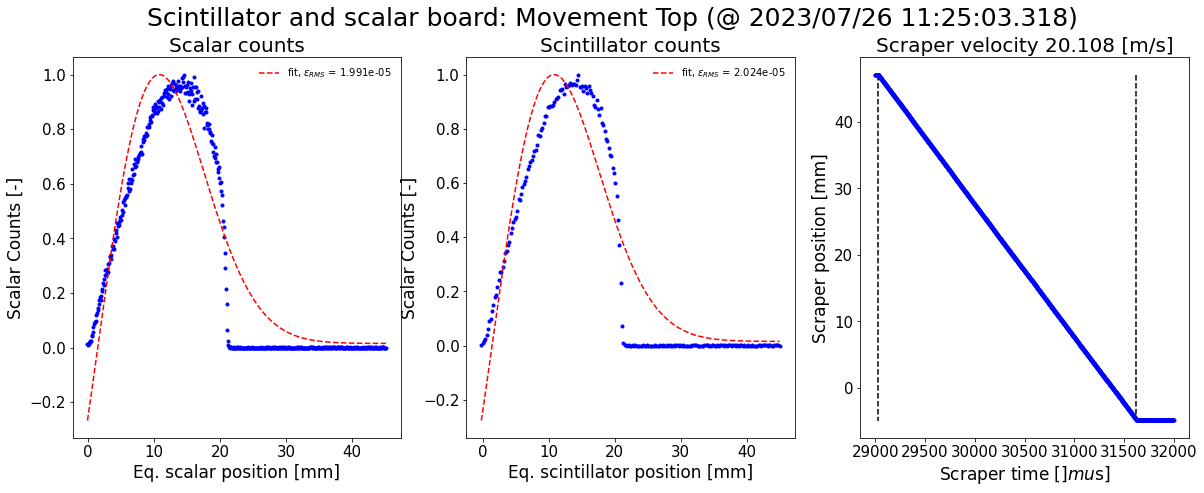

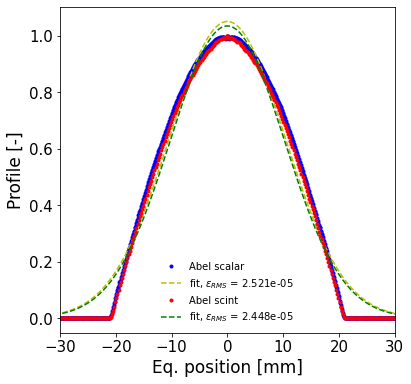

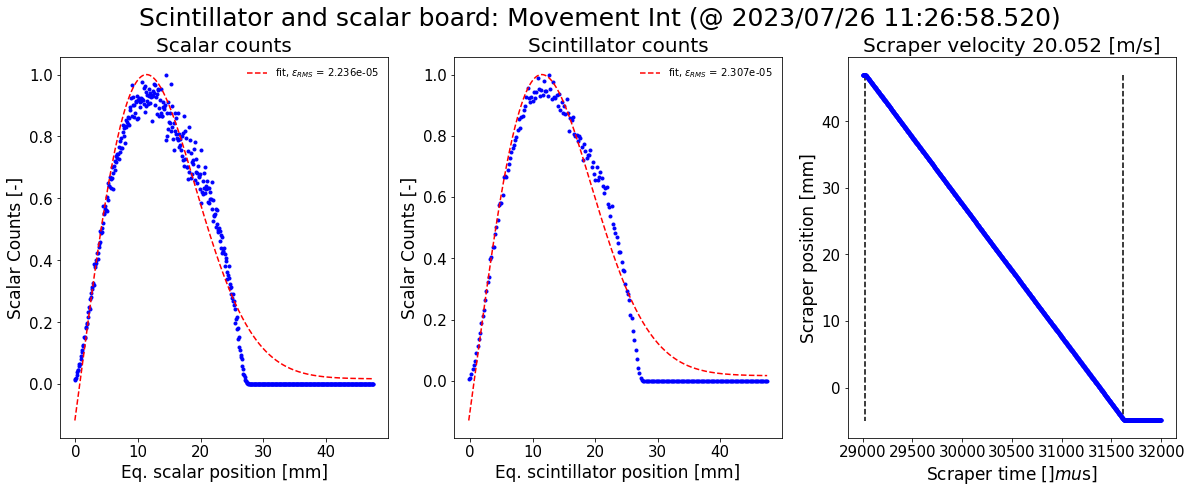

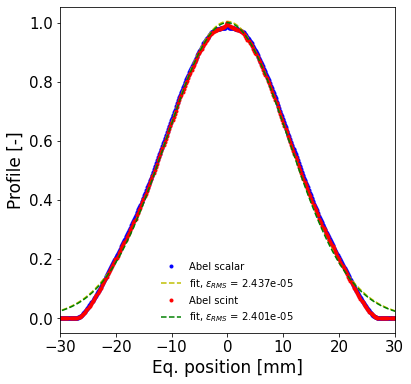

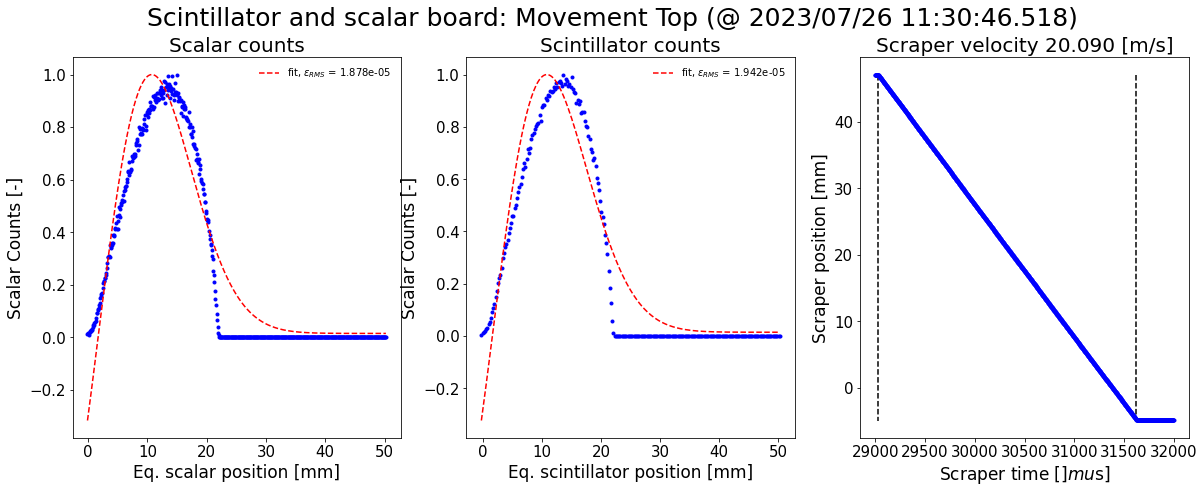

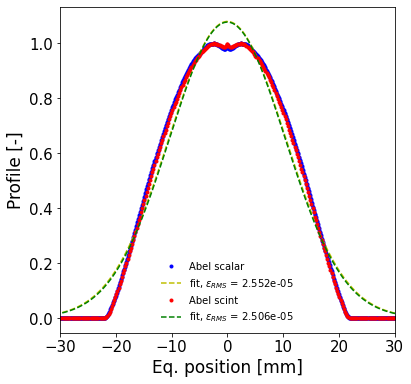

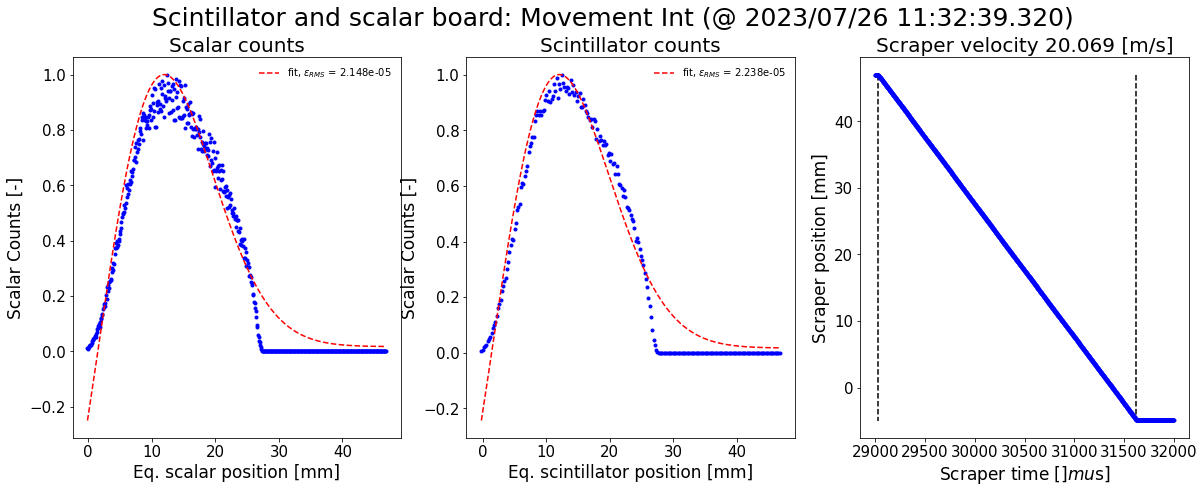

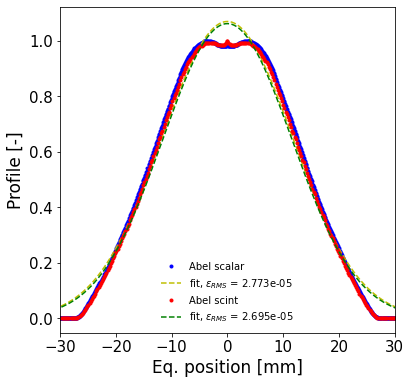

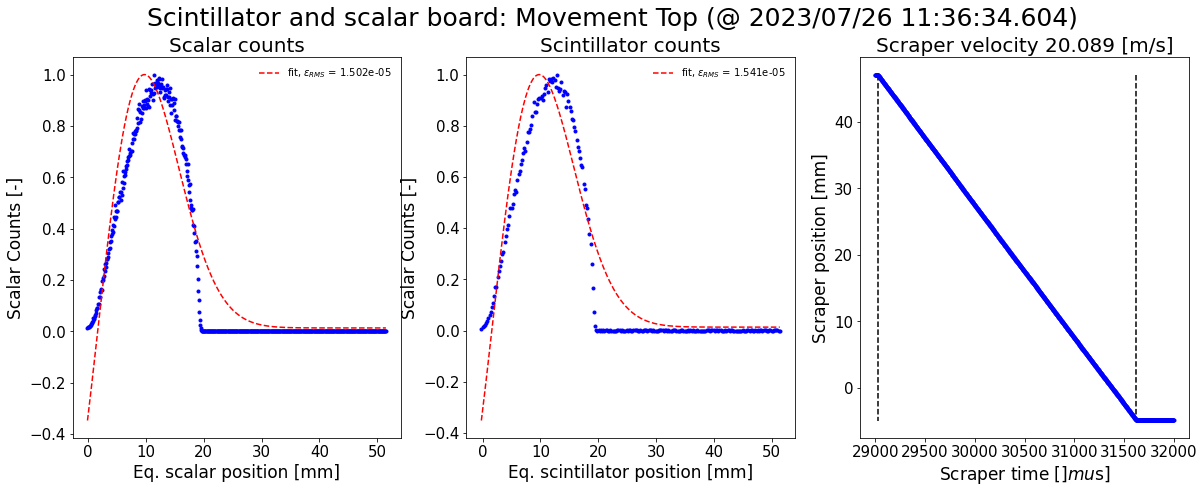

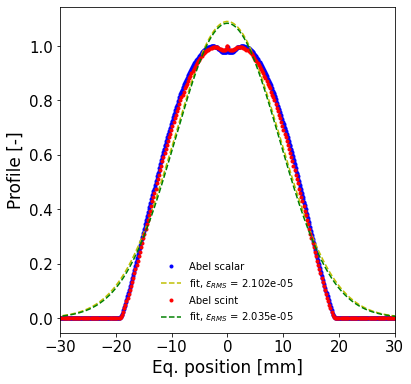

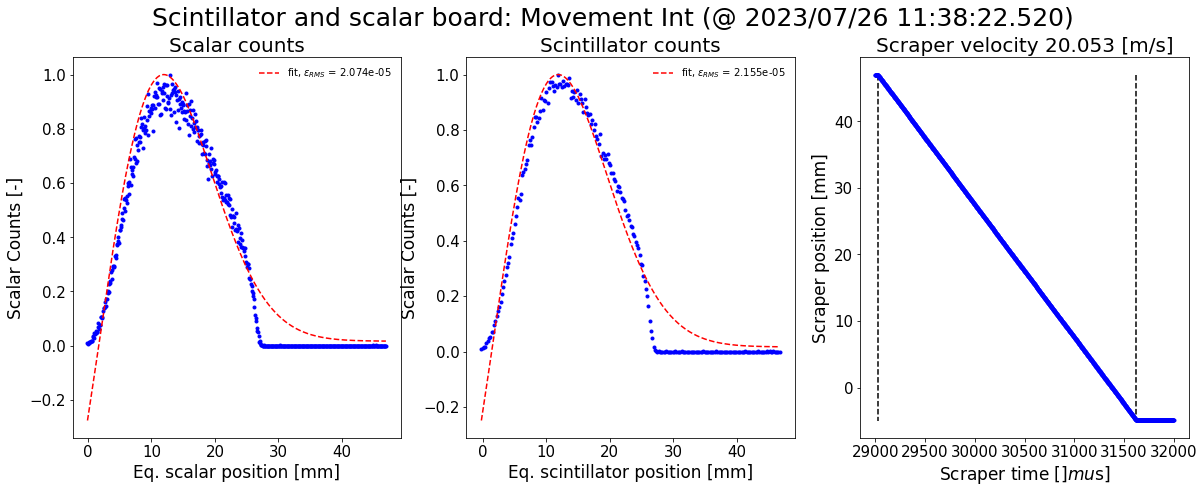

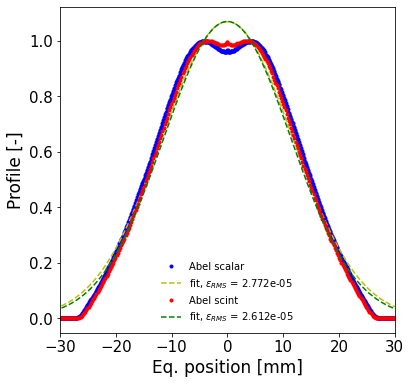

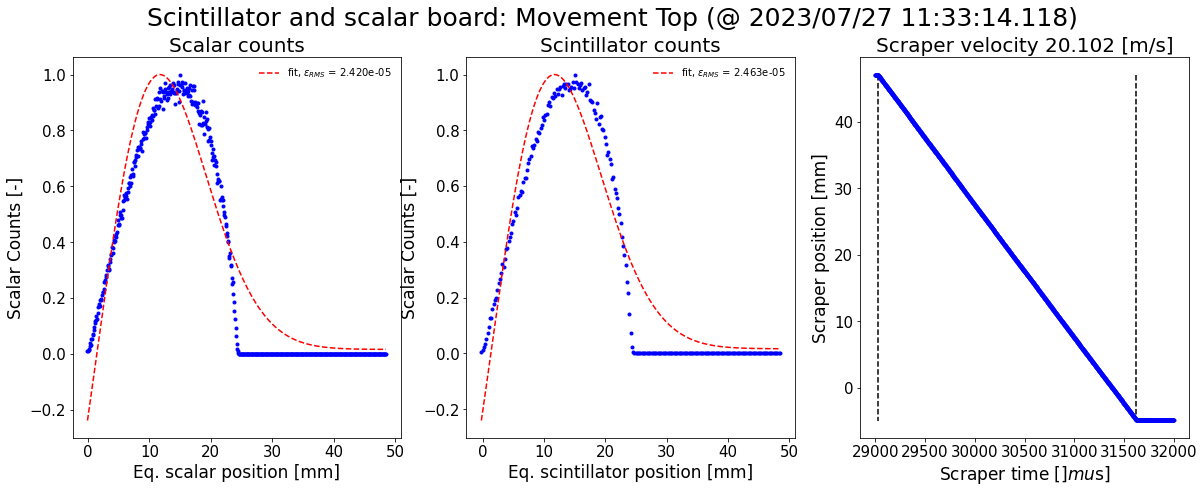

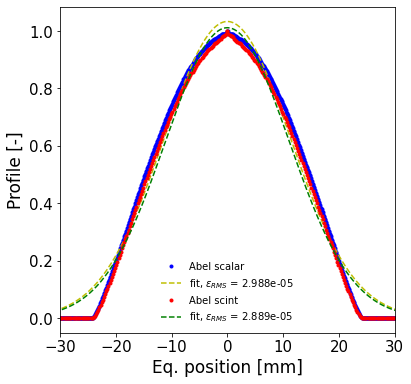

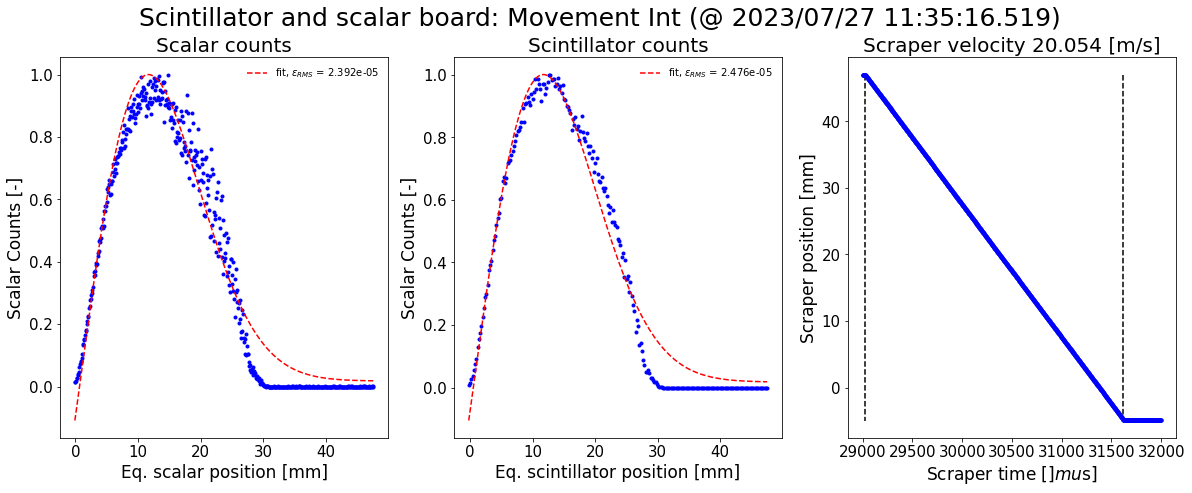

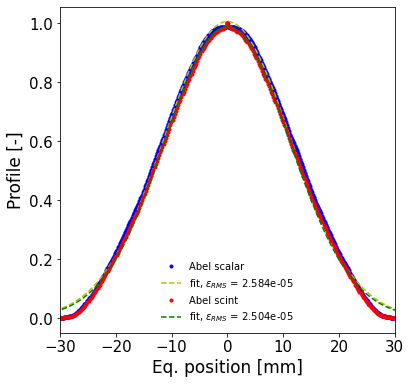

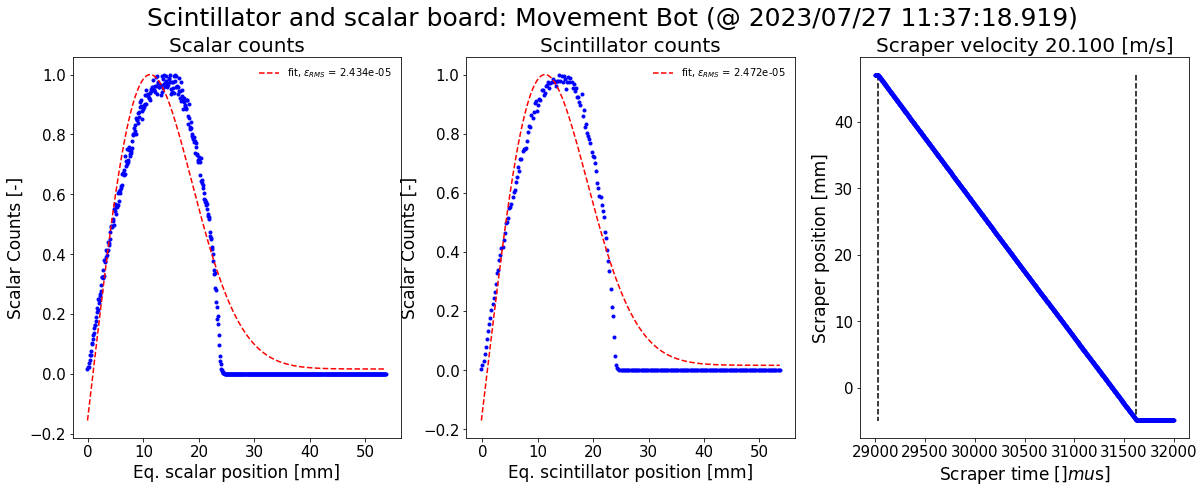

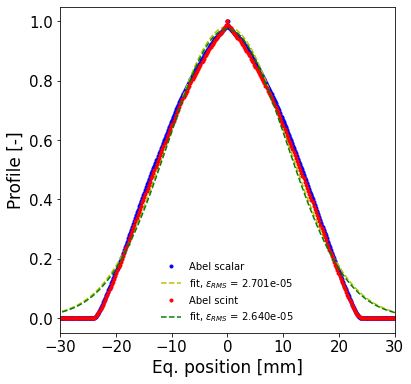

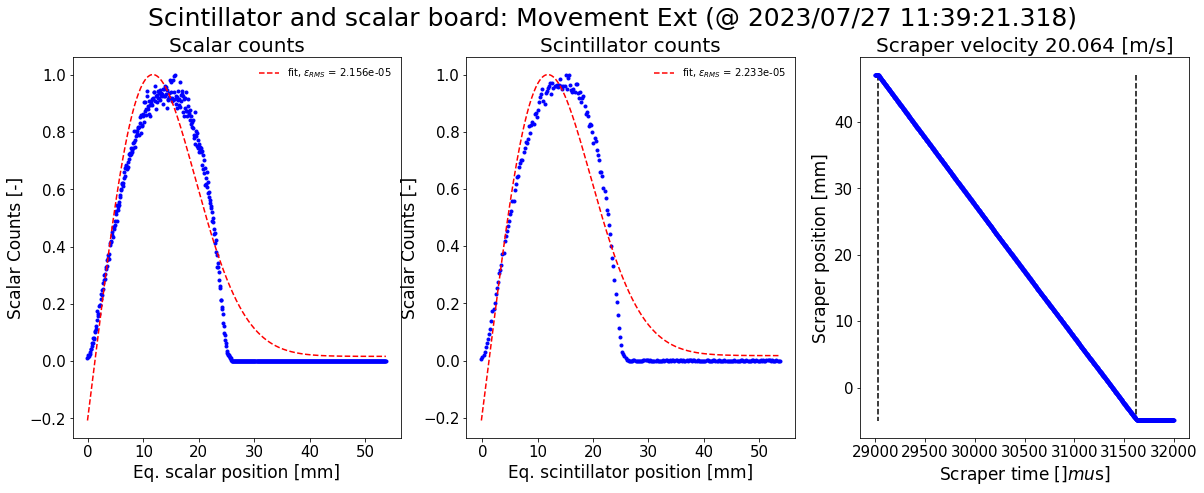

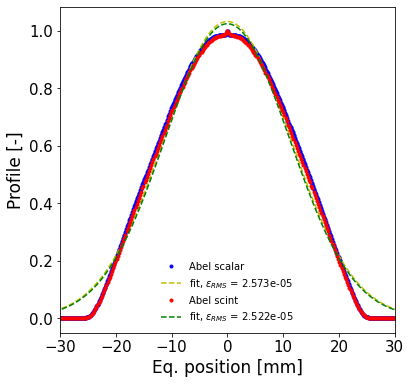

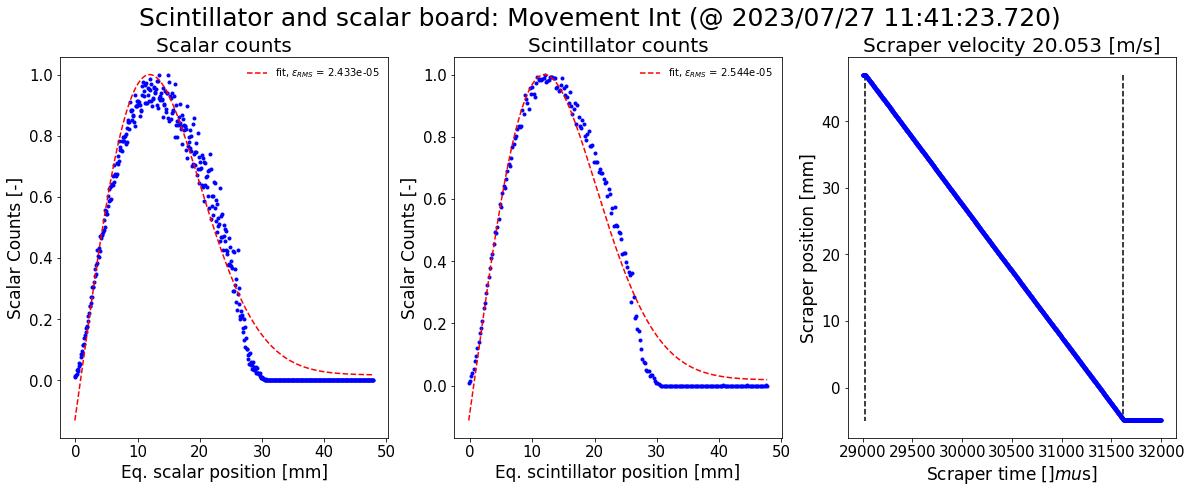

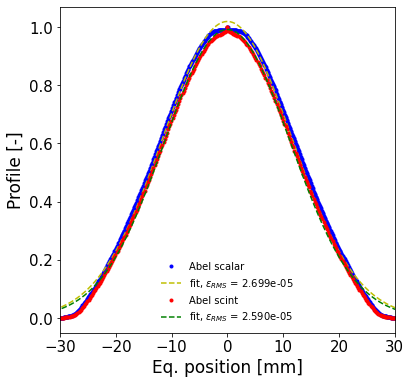

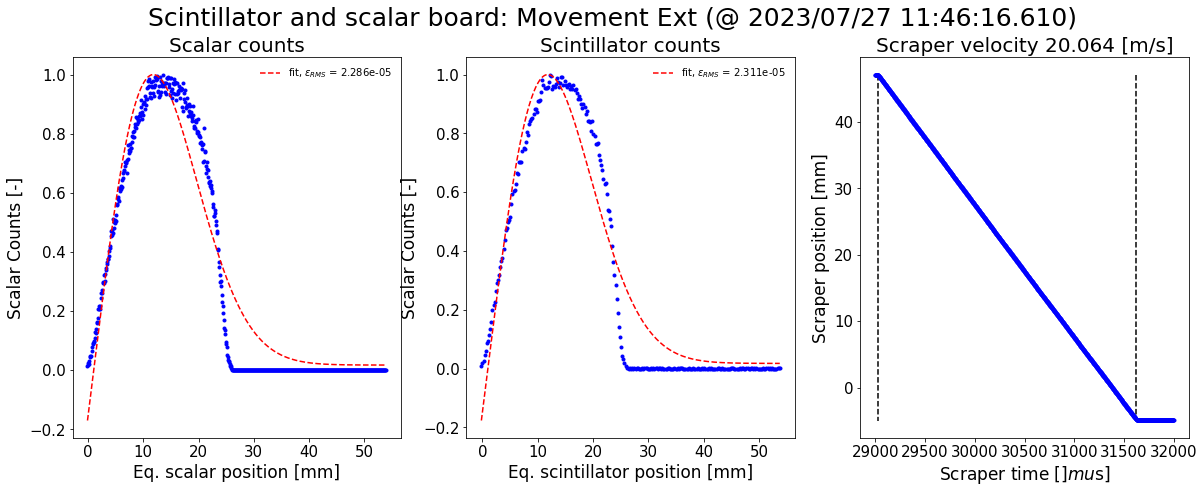

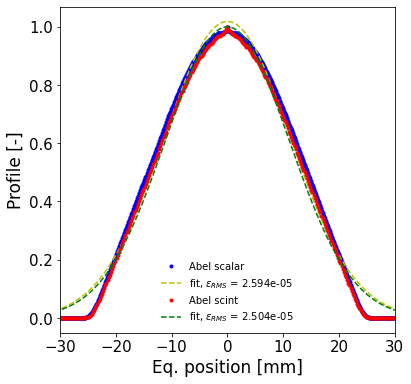

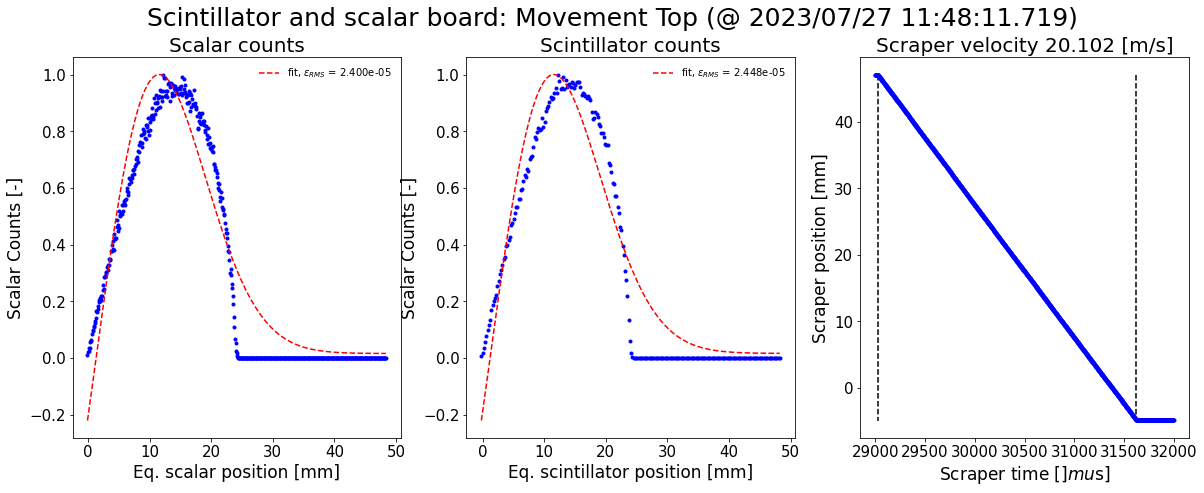

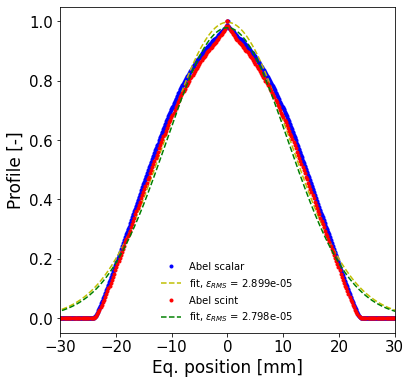

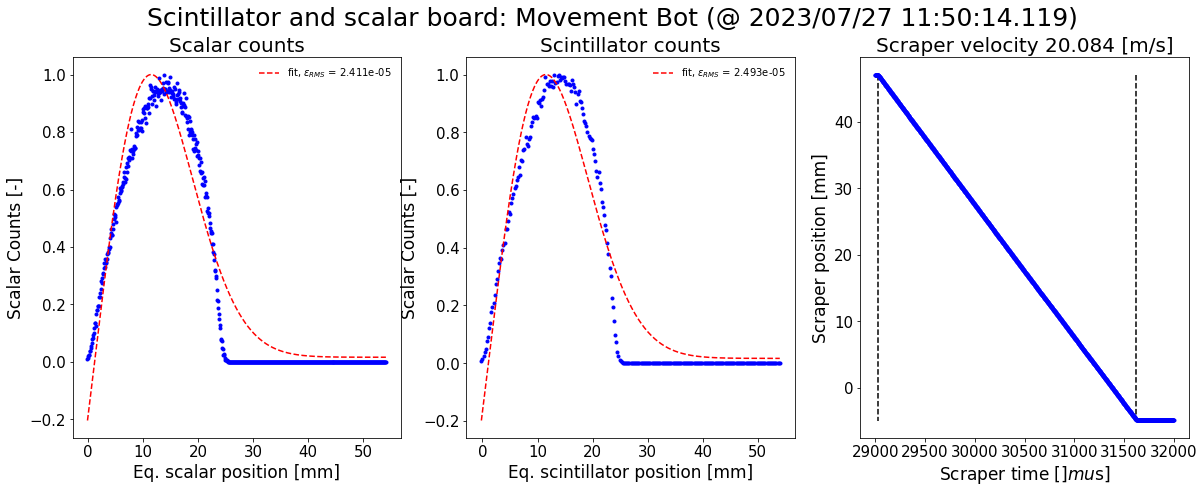

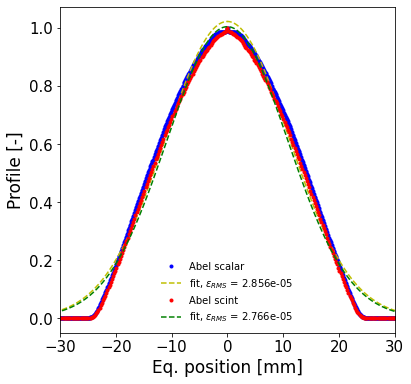

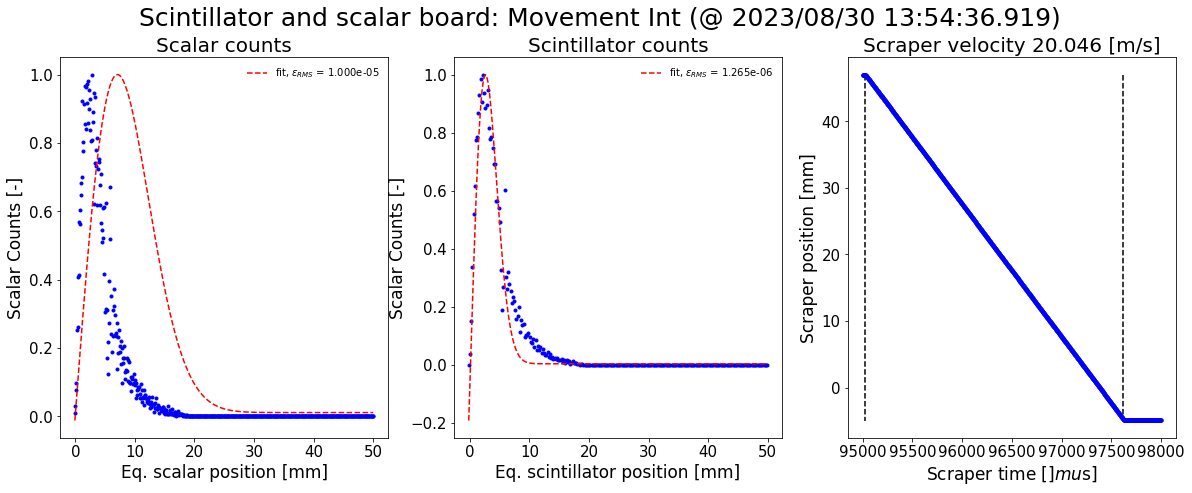

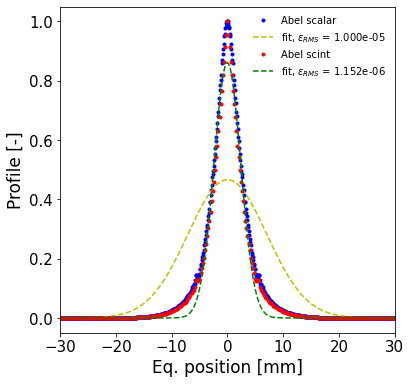

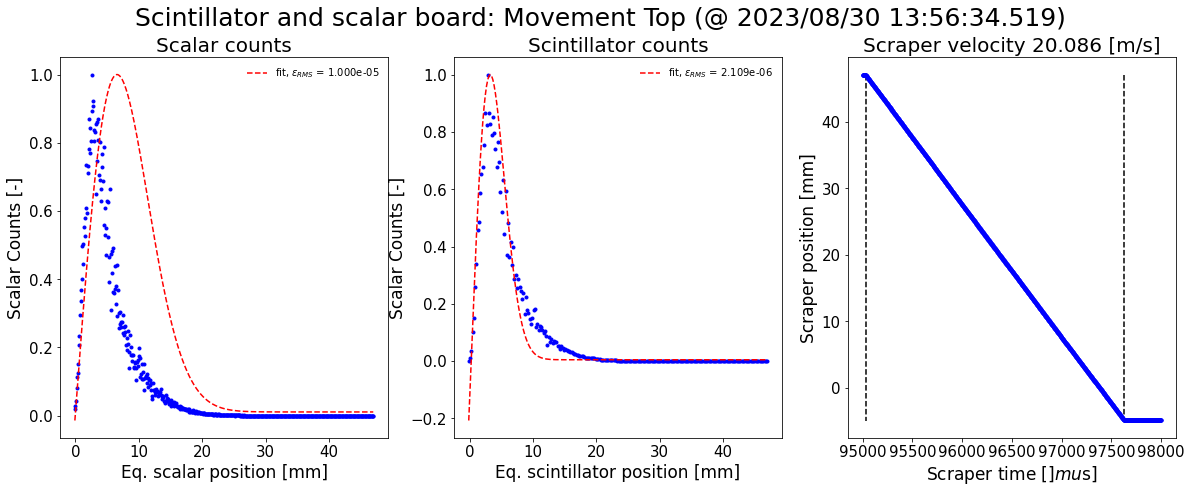

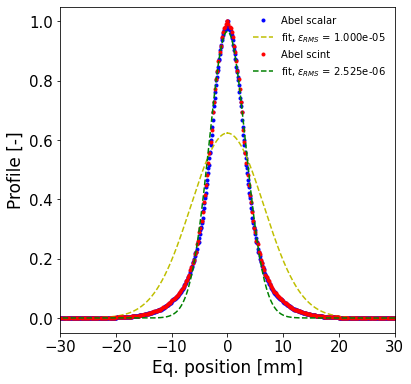

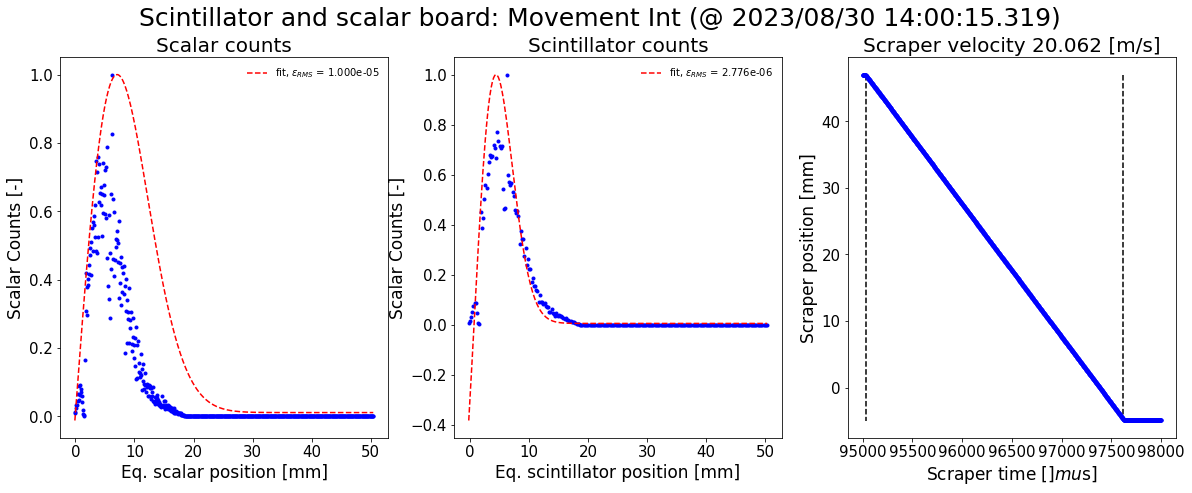

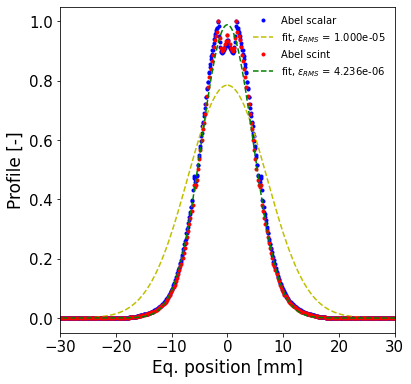

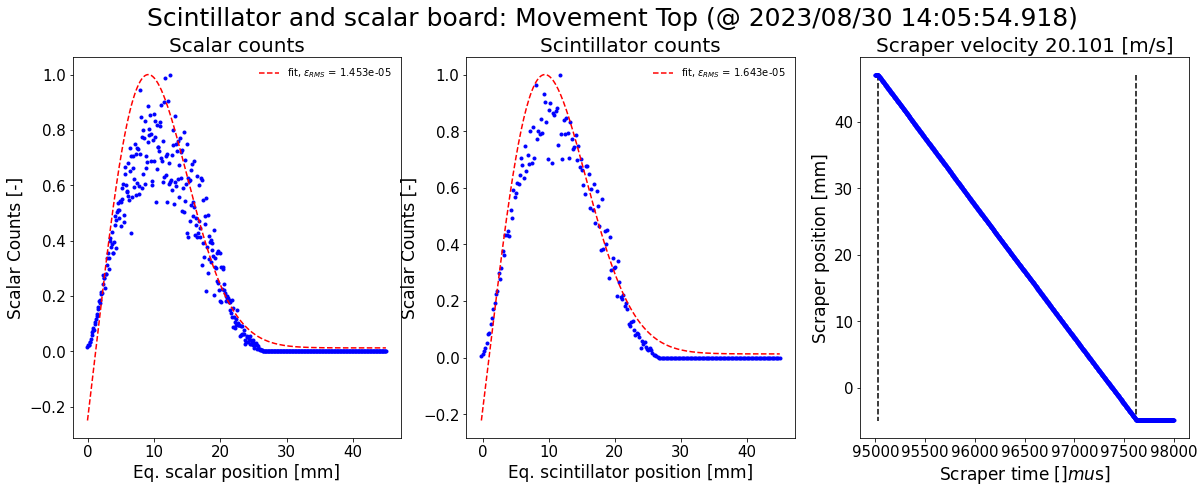

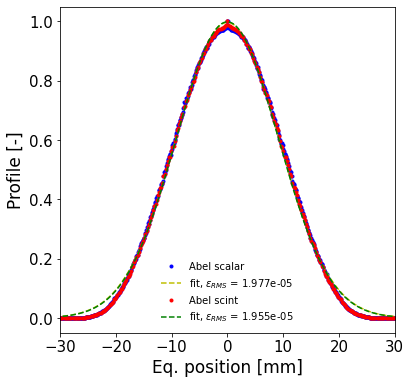

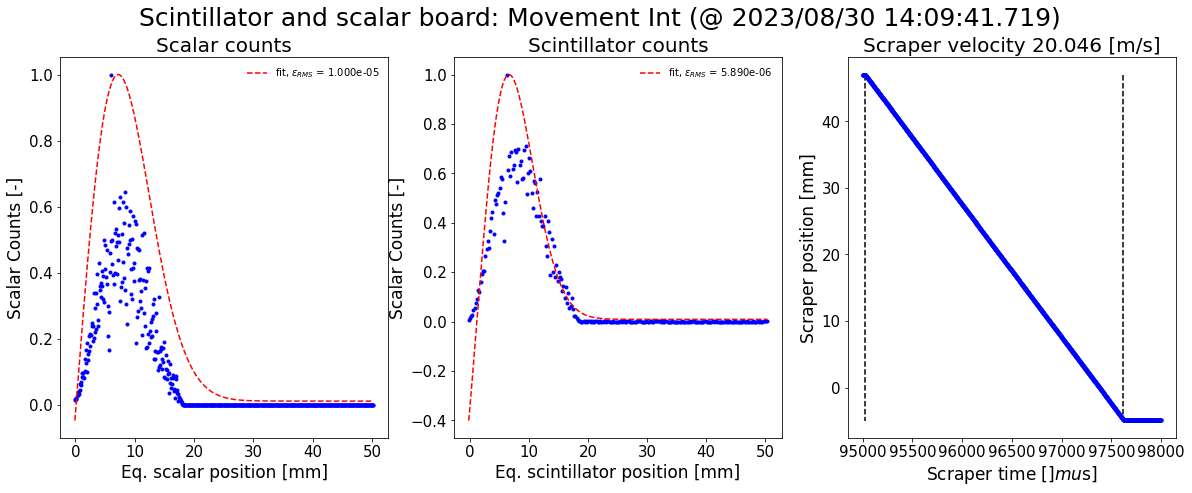

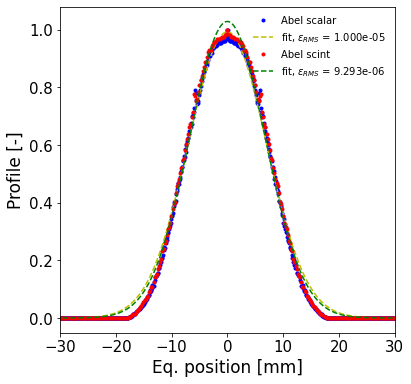

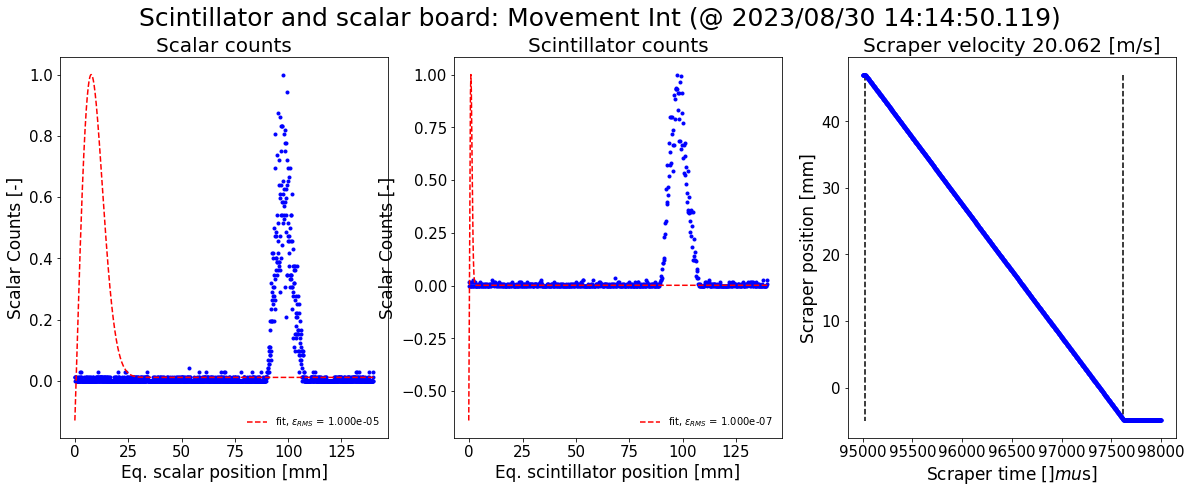

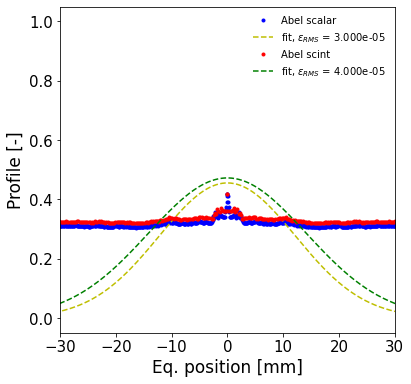

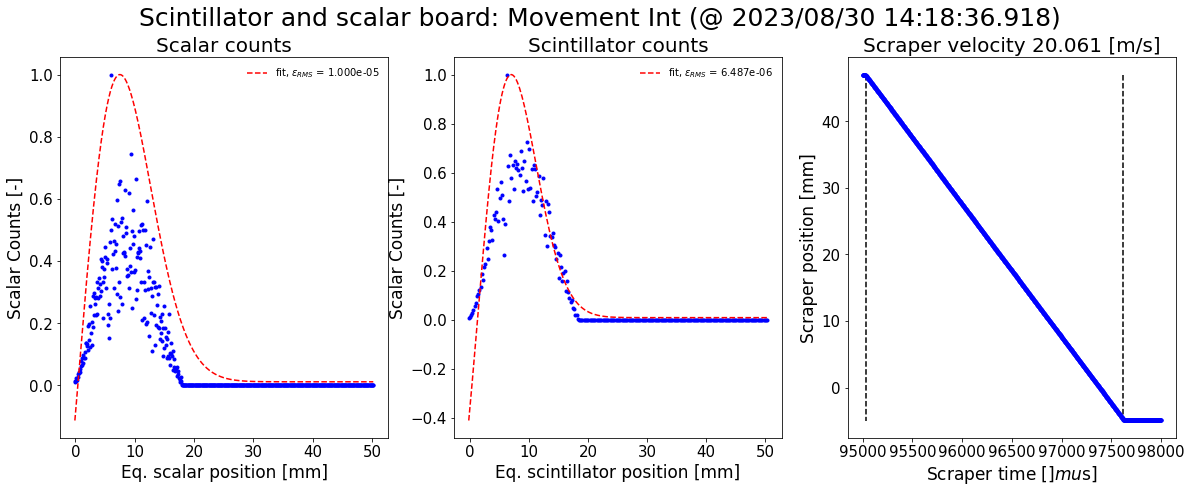

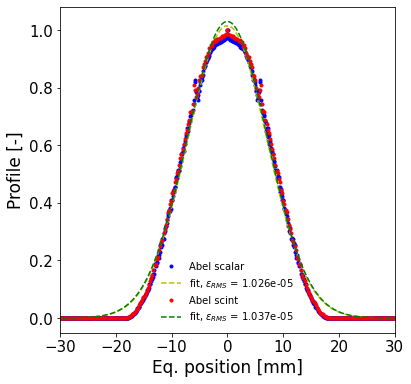

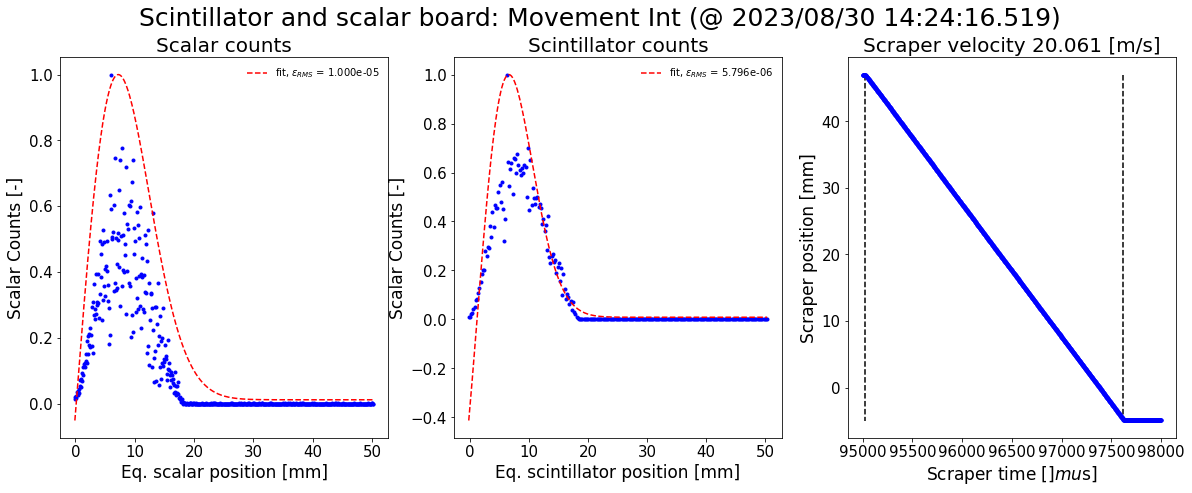

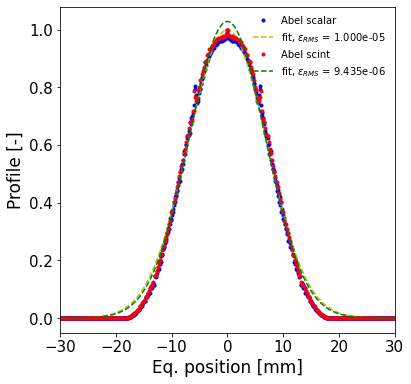

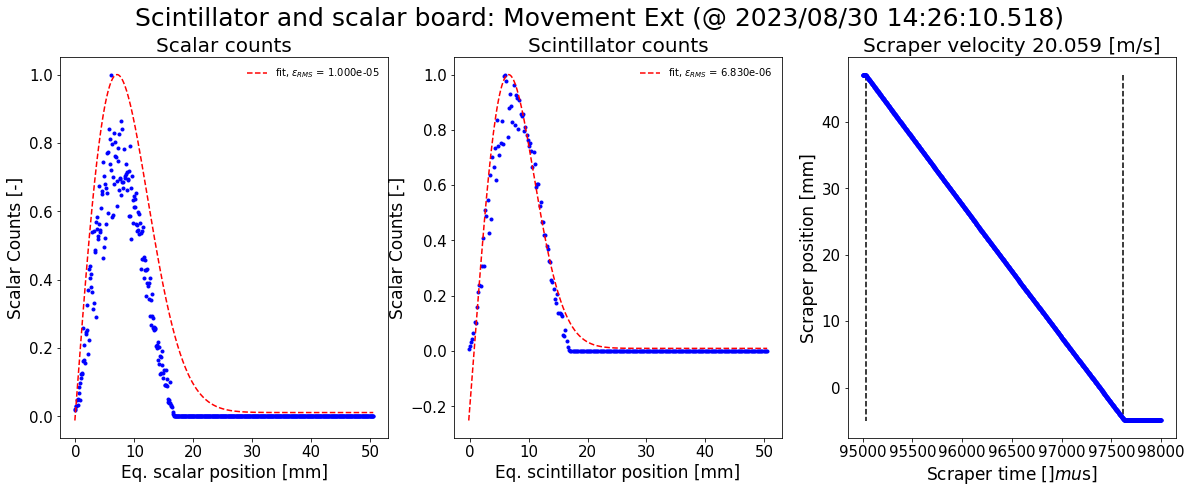

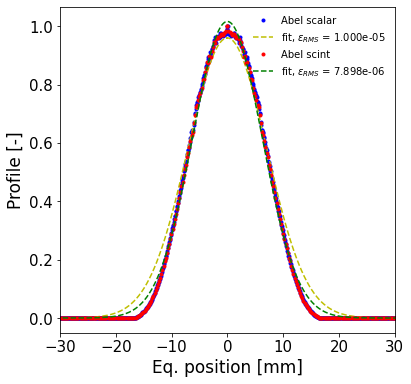

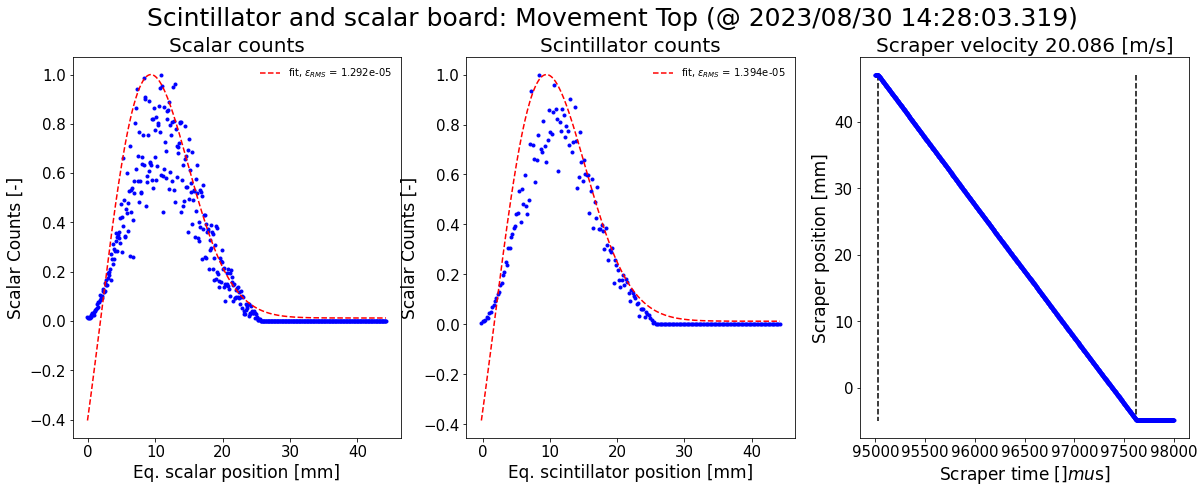

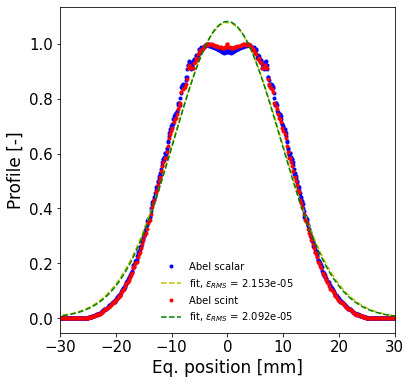

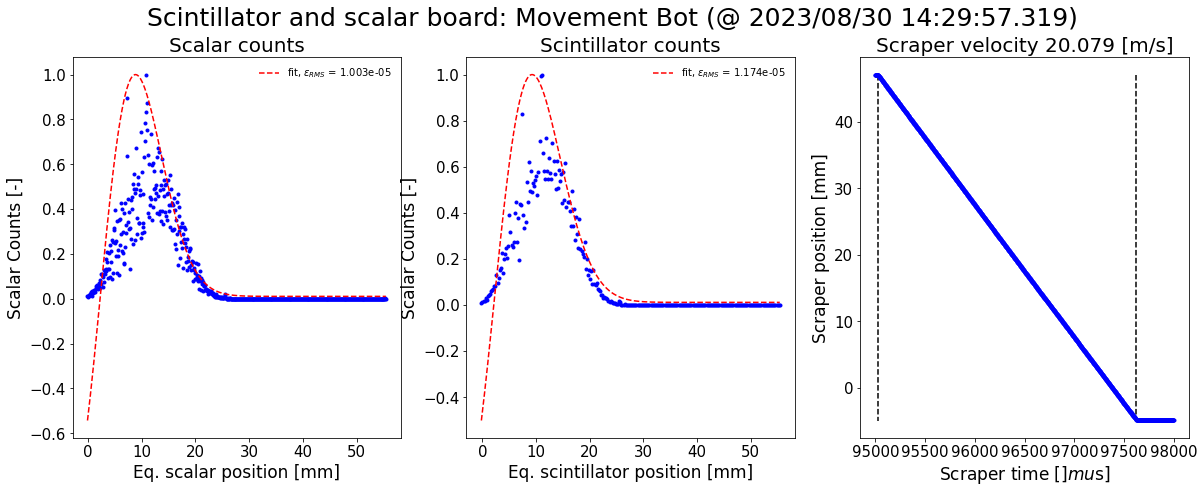

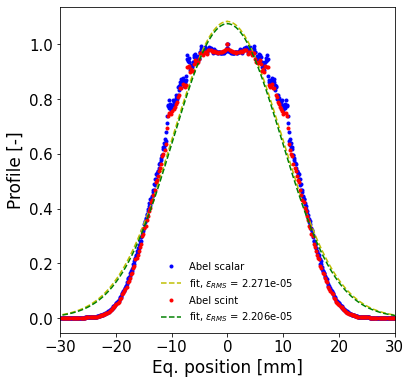

In [13]:
Emittance_Scalar = []
Emittance_Scintillator = []
Emittance_Scalar_Losses = []
Emittance_Scintillator_Losses = []

Amplitude = []
Amplitude_Scint = []

Integral_Scalar = []
Integral_Scintillator = []
Integral_Scalar_Fit = []
Integral_Scintillator_Fit = []
Integral_Scalar_Losses = []
Integral_Scintillator_Losses = []
Integral_Scalar_Losses_Fit = []
Integral_Scintillator_Losses_Fit = []

for h in range(len(df.originUtcTime.values)):    
    f, ax = plt.subplots(1, 3, figsize = (20, 7), sharex = False, sharey = False)
    f.suptitle("Scintillator and scalar board: Movement %s (@ %s)"%(df.scraperDirection.iloc[h], df.dataScraperOriginTime.iloc[h]), size = 25)

    f1, axP = plt.subplots(1, 1, figsize = (6, 6), sharex = False, sharey = False)
    
    if (df.scraperDirection.iloc[h] == "Bot") or (df.scraperDirection.iloc[h] == "Top"):
        beta_scraper = 4.288
        ScraperLossesFit = ScraperLosses_V
        GaussFit = Gauss_Fit_V
    else:
        beta_scraper = 4.975
        ScraperLossesFit = ScraperLosses_H
        GaussFit = Gauss_Fit_H
    
    ScraperStart = np.where(np.diff(np.array(df.scraperY.iloc[h]))<-0.03)[0][0]
    ScraperEnd = np.where(np.diff(np.array(df.scraperY.iloc[h]))<-0.03)[0][-1]

    delta_time_scraper = np.abs(df.scraperXms.iloc[h][ScraperStart] - df.scraperXms.iloc[h][ScraperEnd] )

    VelocityScraper = (max(df.scraperY.iloc[h]) - min(df.scraperY.iloc[h])) / delta_time_scraper
    
    #################################################    scalar plot     #################################################
    ax[0].set_title("Scalar counts", size = 20)

    ydata_scalar = np.array(df["det3.yval"].iloc[h][0])[::-1]
    xdata_scalar = np.array(df["det3.xms"].iloc[h]) * VelocityScraper

    limit = 0.01
    if np.mean(ydata_scalar)>1:
        ind_minlosses = np.where(ydata_scalar/max(ydata_scalar)>limit)[0][0]+1

        ax[0].plot( xdata_scalar[ind_minlosses-1:]-xdata_scalar[ind_minlosses], ydata_scalar[ind_minlosses-1:]/max(ydata_scalar), ".b" )
        Integral_Scalar_Losses = np.append(Integral_Scalar_Losses, np.trapz(ydata_scalar[ind_minlosses-1:], x = (xdata_scalar[ind_minlosses-1:]-xdata_scalar[ind_minlosses])*1e-3))

        ####Fit procedure
        opt_coeff, opt_covar = spopt.curve_fit(ScraperLossesFit, 
                                               (xdata_scalar[ind_minlosses-1:]-xdata_scalar[ind_minlosses])*1e-3, 
                                                ydata_scalar[ind_minlosses-1:]/max(ydata_scalar), 
                                               p0 = [25e-6, 0.1e-3], 
                                              bounds = ([10e-6, 1e-5], [30e-6, 1e-2]))
        ax[0].plot(xdata_scalar[ind_minlosses-1:]-xdata_scalar[ind_minlosses], ScraperLossesFit((xdata_scalar[ind_minlosses-1:]-xdata_scalar[ind_minlosses])*1e-3, *opt_coeff), 
                   ls = "--", color = "r", label = "fit, $\epsilon_{RMS}$ = %1.3e"%opt_coeff[0])

        Integral_Scalar_Losses_Fit = np.append(Integral_Scalar_Losses_Fit, np.trapz(ScraperLossesFit((xdata_scalar[ind_minlosses-1:]-xdata_scalar[ind_minlosses])*1e-3, *opt_coeff), 
                                                                                    x = (xdata_scalar[ind_minlosses-1:]-xdata_scalar[ind_minlosses])*1e-3 ) )
        Emittance_Scalar_Losses = np.append(Emittance_Scalar_Losses, opt_coeff[0]*1e6)
        ax[0].set_xlabel("Eq. scalar position [mm]", size = 17)
        ax[0].set_ylabel("Scalar Counts [-]", size = 17)
        ax[0].tick_params(axis = "both", which = "major", labelsize = 15)
        ax[0].legend(frameon = False)
    #     ax[0].set_xlim([-1, 20])

        # reconstruction profile with ABEL
        x_pos, y_pos = (xdata_scalar[ind_minlosses-1:]-xdata_scalar[ind_minlosses]), ydata_scalar[ind_minlosses-1:]/max(ydata_scalar)
        GiuliaAbelTransform, i_max, x_scraper_OverSampled = ForwardAbelTransform(*(x_pos, y_pos), MinValueLosses = limit, 
                                                                                 MinPointsInRisingEdge = 0, 
                                                                                 MaximumOffset = 0)

        x_Abel = np.concatenate(( np.sort(x_scraper_OverSampled*(-1)*1e-3), x_scraper_OverSampled*1e-3 ))
        y_Abel = np.concatenate(( GiuliaAbelTransform[::-1]/max(GiuliaAbelTransform), GiuliaAbelTransform/max(GiuliaAbelTransform) ))

        axP.plot(x_Abel*1e3, y_Abel, ls = " ", marker = ".", color = "b", label = "Abel scalar")
        # fit on abel profile
        opt_coeff, opt_covar = spopt.curve_fit(GaussFit, x_Abel, y_Abel, 
                                               p0 = [0.2, 25e-6], bounds = ([0, 10e-6],[10, 30e-6]),
                                               check_finite = False, maxfev = 5000)
        axP.plot(x_Abel*1e3, GaussFit(x_Abel, *opt_coeff), ls = "--", color = "y", label = "fit, $\epsilon_{RMS}$ = %1.3e"%opt_coeff[-1])
        Amplitude = np.append(Amplitude, opt_coeff[0])

        axP.legend(frameon = False)
        axP.set_xlim([-10, 10])

        Emittance_Scalar = np.append(Emittance_Scalar, opt_coeff[-1]*1e6)
        Integral_Scalar = np.append(Integral_Scalar, np.trapz(y_Abel, x = x_Abel))
        Integral_Scalar_Fit = np.append(Integral_Scalar_Fit, np.trapz(GaussFit(x_Abel, *opt_coeff), x = x_Abel))
    else:
        Integral_Scalar_Losses = np.append(Integral_Scalar_Losses, np.nan)
        Integral_Scalar_Losses_Fit = np.append(Integral_Scalar_Losses_Fit, np.nan )
        Emittance_Scalar_Losses = np.append(Emittance_Scalar_Losses, np.nan)
        Emittance_Scalar = np.append(Emittance_Scalar, np.nan)
        Integral_Scalar = np.append(Integral_Scalar, np.nan)
        Integral_Scalar_Fit = np.append(Integral_Scalar_Fit, np.nan)
    #################################################    scintillator plot     #################################################
    ax[1].set_title("Scintillator counts", size = 20)
    xdata_scint = np.array(df["det1.xms"].iloc[h])*VelocityScraper
    ydata_scint = np.array(df["det1.yval"].iloc[h][0])[::-1]
    ind_minlosses = np.where(ydata_scint/max(ydata_scint)>limit)[0][0]
    
    ax[1].plot( xdata_scint[ind_minlosses-1:] - xdata_scint[ind_minlosses], ydata_scint[ind_minlosses-1:]/max(ydata_scint), ".b" )
    Integral_Scintillator_Losses = np.append(Integral_Scintillator_Losses, np.trapz(ydata_scint[ind_minlosses-1:], x = (xdata_scint[ind_minlosses-1:]-xdata_scint[ind_minlosses])*1e-3))
    ####Fit procedure
    opt_coeff, opt_covar = spopt.curve_fit(ScraperLossesFit, (xdata_scint[ind_minlosses-1:]-xdata_scint[ind_minlosses])*1e-3, ydata_scint[ind_minlosses-1:]/max(ydata_scint), 
                                           p0 = [25e-6, 1e-3], bounds = ([10e-8, 1e-4], [40e-6, 1e-2]))
    ax[1].plot(xdata_scint[ind_minlosses-1:]-xdata_scint[ind_minlosses], ScraperLossesFit((xdata_scint[ind_minlosses-1:]-xdata_scint[ind_minlosses])*1e-3, *opt_coeff), 
               ls = "--", color = "r", label = "fit, $\epsilon_{RMS}$ = %1.3e"%opt_coeff[0])
    
    Integral_Scintillator_Losses_Fit = np.append(Integral_Scintillator_Losses_Fit, np.trapz(ScraperLossesFit((xdata_scint[ind_minlosses-1:]-xdata_scint[ind_minlosses])*1e-3, *opt_coeff), 
                                                                                            x = (xdata_scint[ind_minlosses-1:]-xdata_scint[ind_minlosses])*1e-3 ) )
    Emittance_Scintillator_Losses = np.append(Emittance_Scintillator_Losses, opt_coeff[0]*1e6)
    
    ax[1].set_xlabel("Eq. scintillator position [mm]", size = 17)
    ax[1].set_ylabel("Scalar Counts [-]", size = 17)
    ax[1].tick_params(axis = "both", which = "major", labelsize = 15)
    ax[1].legend(frameon = False)
#     ax[1].set_xlim([-1, 20])
    
    # reconstruction profile with ABEL
    x_pos, y_pos = (xdata_scint[ind_minlosses-1:]-xdata_scint[ind_minlosses]), ydata_scint[ind_minlosses-1:]/max(ydata_scint)
    GiuliaAbelTransform, i_max, x_scraper_OverSampled = ForwardAbelTransform(*(x_pos, y_pos), MinValueLosses = limit, 
                                                                             MinPointsInRisingEdge = 0, 
                                                                             MaximumOffset = 0)
    
    x_Abel = np.concatenate(( np.sort(x_scraper_OverSampled*(-1)*1e-3), x_scraper_OverSampled*1e-3 ))
    y_Abel = np.concatenate(( GiuliaAbelTransform[::-1]/max(GiuliaAbelTransform), GiuliaAbelTransform/max(GiuliaAbelTransform) ))
    
    axP.plot(x_Abel*1e3, y_Abel, ls = " ", marker = ".", color = "r", label = "Abel scint")
#     # fit on abel profile
    opt_coeff, opt_covar = spopt.curve_fit(GaussFit, x_Abel, y_Abel, 
                                           p0 = [0.02, 25e-6], bounds = ([0, 10e-8],[10, 40e-6]), check_finite = False)
    axP.plot(x_Abel*1e3, GaussFit(x_Abel, *opt_coeff), ls = "--", color = "g", label = "fit, $\epsilon_{RMS}$ = %1.3e"%opt_coeff[-1])
    Amplitude_Scint = np.append(Amplitude_Scint, opt_coeff[0])
    axP.legend(frameon = False)
    
    
    axP.set_xlabel("Eq. position [mm]", size = 17)
    axP.set_ylabel("Profile [-]", size = 17)
    axP.tick_params(axis = "both", which = "major", labelsize = 15)
    axP.legend(frameon = False)
    axP.set_xlim([-30, 30])
    
    Emittance_Scintillator = np.append(Emittance_Scintillator, opt_coeff[-1]*1e6)
    Integral_Scintillator = np.append(Integral_Scintillator, np.trapz(y_Abel, x = x_Abel))
    Integral_Scintillator_Fit = np.append(Integral_Scintillator_Fit, np.trapz(GaussFit(x_Abel, *opt_coeff), x = x_Abel))
    #################################################    scraper plot     #################################################
    ax[2].set_title("Scraper velocity %1.3f [m/s]"%(VelocityScraper*1e3), size = 20)
    ax[2].plot(df["scraperXms"].iloc[h], df["scraperY"].iloc[h], ".b" )
    
    ax[2].vlines(x = df["scraperXms"].iloc[h][ScraperStart],ymin = max(df["scraperY"].iloc[h]), ymax = min(df["scraperY"].iloc[0]), 
                 color = "k", ls = "--")
    ax[2].vlines(x = df["scraperXms"].iloc[h][ScraperEnd],ymin = max(df["scraperY"].iloc[h]), ymax = min(df["scraperY"].iloc[0]), 
                 color = "k", ls = "--")
    
    ax[2].set_xlabel("Scraper time [$]mu$s]", size = 17)
    ax[2].set_ylabel("Scraper position [mm]", size = 17)
    ax[2].tick_params(axis = "both", which = "major", labelsize = 15)

In [14]:
df["Emittance_Scalar"] = Emittance_Scalar*6
df["Emittance_Scintillator"] = Emittance_Scintillator*6
df["Emittance_Scalar_Losses"] = Emittance_Scalar_Losses*6
df["Emittance_Scintillator_Losses"] = Emittance_Scintillator_Losses*6

df["Integral_Scalar"] = Integral_Scalar
df["Integral_Scintillator"] = Integral_Scintillator
df["Integral_Scalar_Fit"] = Integral_Scalar_Fit
df["Integral_Scintillator_Fit"] = Integral_Scintillator_Fit

df["Integral_Scalar_Losses"] = Integral_Scalar_Losses
df["Integral_Scintillator_Losses"] = Integral_Scintillator_Losses
df["Integral_Scalar_Losses_Fit"] = Integral_Scalar_Losses_Fit
df["Integral_Scintillator_Losses_Fit"] = Integral_Scintillator_Losses_Fit

In [15]:
df = df.sort_values('dataScraperOriginTime')

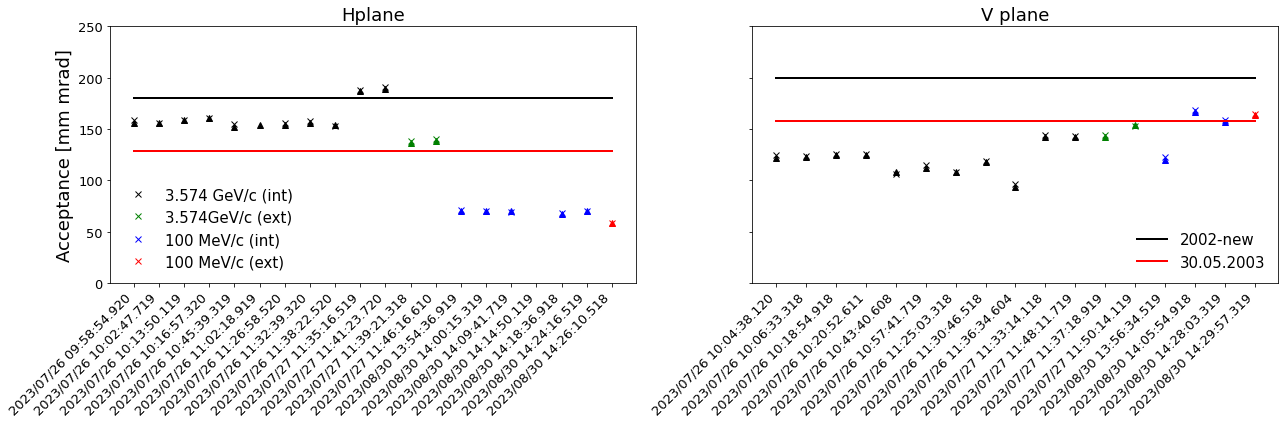

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6), sharex = False, sharey = True)


ax1.set_title("Hplane", size = 18)

ax1.plot(df[(df["scraperDirection"] == "Int") & (df["startScraperDelay"] < 90000) ].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Int") & (df["startScraperDelay"] < 90000) ].AcceptanceScalar, "xk", label = "3.574 GeV/c (int)")
ax1.plot(df[(df["scraperDirection"] == "Int") & (df["startScraperDelay"] < 90000) ].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Int") & (df["startScraperDelay"] < 90000) ].AcceptanceScintillator, "^k")

ax1.plot(df[ (df["scraperDirection"] == "Ext") & (df["startScraperDelay"] < 90000)].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Ext") & (df["startScraperDelay"] < 90000)].AcceptanceScalar, "xg", label = "3.574GeV/c (ext)")
ax1.plot(df[ (df["scraperDirection"] == "Ext") & (df["startScraperDelay"] < 90000)].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Ext") & (df["startScraperDelay"] < 90000)].AcceptanceScintillator, "^g")

ax1.plot(df[(df["scraperDirection"] == "Int") & (df["startScraperDelay"] > 90000) ].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Int") & (df["startScraperDelay"] > 90000) ].AcceptanceScalar, "xb", label = "100 MeV/c (int)")
ax1.plot(df[(df["scraperDirection"] == "Int") & (df["startScraperDelay"] > 90000) ].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Int") & (df["startScraperDelay"] > 90000) ].AcceptanceScintillator, "^b")

ax1.plot(df[ (df["scraperDirection"] == "Ext") & (df["startScraperDelay"] > 90000)].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Ext") & (df["startScraperDelay"] > 90000)].AcceptanceScalar, "xr",  label = "100 MeV/c (ext)")
ax1.plot(df[ (df["scraperDirection"] == "Ext") & (df["startScraperDelay"] > 90000)].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Ext") & (df["startScraperDelay"] > 90000)].AcceptanceScintillator, "^r")

ax1.plot([min(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime),
          max(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime)],[180, 180], "-k", lw = 2)
ax1.plot([min(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime),
          max(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime)],[129, 129], "-r", lw = 2)


ax1.legend(prop = {"size":15}, frameon = False)
ax1.tick_params(axis = "both", which = "major", labelsize = 13)
ax1.set_ylabel ("Acceptance [mm mrad]", size = 18)


ax2.set_title("V plane", size = 18)

ax2.plot(df[ (df["scraperDirection"] == "Top") & (df["startScraperDelay"] < 90000)].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Top") & (df["startScraperDelay"] < 90000)].AcceptanceScalar, "xk" )
ax2.plot(df[ (df["scraperDirection"] == "Top") & (df["startScraperDelay"] < 90000)].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Top") & (df["startScraperDelay"] < 90000)].AcceptanceScintillator, "^k")

ax2.plot(df[(df["scraperDirection"] == "Bot") & (df["startScraperDelay"] < 90000)].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Bot") & (df["startScraperDelay"] < 90000)].AcceptanceScalar, "xg")
ax2.plot(df[(df["scraperDirection"] == "Bot") & (df["startScraperDelay"] < 90000)].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Bot") & (df["startScraperDelay"] < 90000)].AcceptanceScintillator, "^g")

ax2.plot(df[ (df["scraperDirection"] == "Top") & (df["startScraperDelay"] > 90000)].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Top") & (df["startScraperDelay"] > 90000)].AcceptanceScalar, "xb")
ax2.plot(df[ (df["scraperDirection"] == "Top") & (df["startScraperDelay"] > 90000)].dataScraperOriginTime,
         df[ (df["scraperDirection"] == "Top") & (df["startScraperDelay"] > 90000)].AcceptanceScintillator, "^b")

ax2.plot(df[(df["scraperDirection"] == "Bot") & (df["startScraperDelay"] > 90000)].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Bot") & (df["startScraperDelay"] > 90000)].AcceptanceScalar, "xr")
ax2.plot(df[(df["scraperDirection"] == "Bot") & (df["startScraperDelay"] > 90000)].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Bot") & (df["startScraperDelay"] > 90000)].AcceptanceScintillator, "^r")

ax2.plot([min(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime),
          max(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime)],[200, 200], "-k", lw = 2, label = "2002-new")
ax2.plot([min(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime),
          max(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime)],[158, 158], "-r", lw = 2, label = "30.05.2003")


ax2.legend(prop = {"size":15}, frameon = False, loc = 4)
ax2.tick_params(axis = "both", which = "major", labelsize = 13)

f.autofmt_xdate(rotation=45)

ax1.set_ylim([0, 250])
plt.tight_layout()
# f.savefig('./AcceptanceMeasurements_HighLowEnergy.pdf')

In [17]:
print(np.mean(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].AcceptanceScintillator.values), 
      np.std (df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].AcceptanceScintillator.values), 
      np.mean(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].startScraperDelay.values))

print(np.mean(df[(df["scraperDirection"] == "Top") | (df["scraperDirection"] == "Bot")].AcceptanceScintillator.values), 
      np.std(df[(df["scraperDirection"] == "Top")  | (df["scraperDirection"] == "Bot")].AcceptanceScintillator.values),
      np.mean(df[(df["scraperDirection"] == "Top") | (df["scraperDirection"] == "Bot")].startScraperDelay.values))

320.01520135924596 831.8968808888644 52100.0
130.7537135567352 20.651480047998405 44529.41176470588


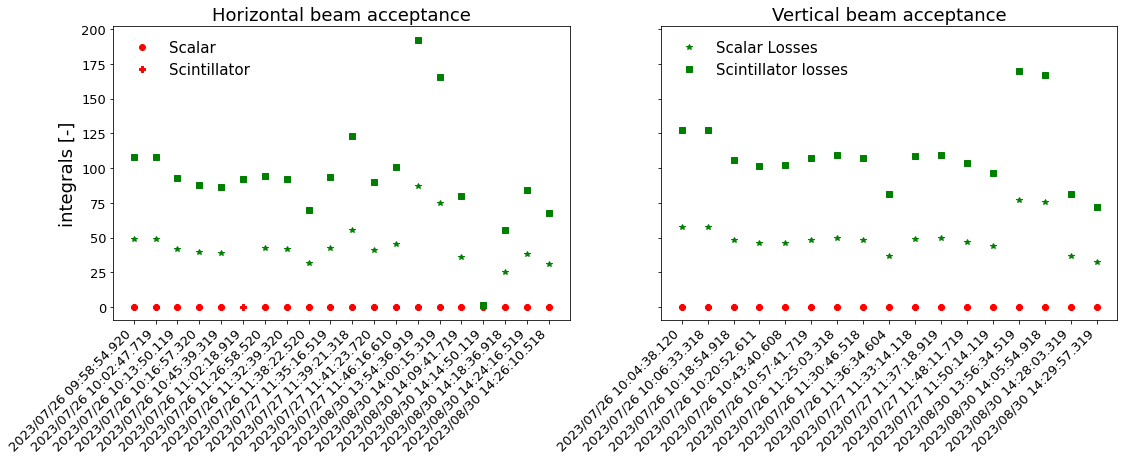

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6), sharex = False, sharey = True)

ax1.set_title("Horizontal beam acceptance", size = 18)
ax1.plot(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].Integral_Scalar, "or", label = "Scalar")
ax1.plot(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].Integral_Scintillator, "Pr", label = "Scintillator")
ax1.plot(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].Integral_Scalar_Losses, "*g")
ax1.plot(df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Int") | (df["scraperDirection"] == "Ext")].Integral_Scintillator_Losses, "sg")

# ax1.fill_betweenx([0, 0.05], "2023/07/19 14:15:35.719", "2023/07/19 15:45:16.520", color = "y", alpha = 0.3 )
# ax1.text( "2023/07/19 14:15:35.719", 0.01, "H orbit correction", size = 13)

# ax1.fill_betweenx([0, 0.05], "2023/07/19 15:45:16.520", "2023/07/19 15:47:08.119", color = "c", alpha = 0.2 )


ax1.legend(prop = {"size":15}, frameon = False, loc = 2)
ax1.tick_params(axis = "both", which = "major", labelsize = 13)
ax1.set_ylabel ("integrals [-]", size = 18)


ax2.set_title("Vertical beam acceptance", size = 18)
ax2.plot(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].Integral_Scalar, "or")
ax2.plot(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].Integral_Scintillator, "Pr")
ax2.plot(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].Integral_Scalar_Losses, "*g", label = "Scalar Losses")
ax2.plot(df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].dataScraperOriginTime,
         df[(df["scraperDirection"] == "Bot") | (df["scraperDirection"] == "Top")].Integral_Scintillator_Losses, "sg", label = "Scintillator losses")

# ax2.fill_betweenx([0, 0.05], "2023/07/19 14:53:56.119", "2023/07/19 15:01:32.118", color = "y", alpha = 0.3 )

# ax2.fill_betweenx([0, 0.05], "2023/07/19 15:49:04.519", "2023/07/19 16:06:09.118", color = "c", alpha = 0.2 )
# ax2.text( "2023/07/19 15:49:04.519", 0.01, "V orbit correction", size = 13)


ax2.legend(prop = {"size":15}, frameon = False, loc = 2)
ax2.tick_params(axis = "both", which = "major", labelsize = 13)

f.autofmt_xdate(rotation=45)